In [1]:
# --- IMPORTS & SETUP ---
import sys
from pathlib import Path
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- PROJECT SETUP ---
# Add the project root to the Python path to allow importing utility modules
PROJECT_ROOT = Path("/home/minhang/mds_project/sc_classification")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# --- UTILITY IMPORTS ---
# Import the necessary classes from our custom utility modules
from utils.experiment_manager import ExperimentManager
from utils.experiment_analysis import ExperimentAnalyzer

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

In [2]:
# --- Base Directory ---
BASE_EXPERIMENT_DIR = PROJECT_ROOT / "experiments"

# --- Experiment Metadata ---
# Dictionary to store information about each experiment run
experiments = {
    "pan_patient_all_filtered": {
        "id": "20250819_230359_fa_100_none_all_filtered_7a2dc57f",
        "label": "Pan-Patient (All Filtered Genes)",
        "type": "pan-patient"
    },
    "per_patient_all_filtered": {
        "id": "20250819_232404_fa_100_random_all_filtered_f85f0e07",
        "label": "Per-Patient (All Filtered Genes)",
        "type": "per-patient"
    },
    "per_patient_deg_weak": {
        "id": "20250820_024407_fa_100_random_deg_weak_screen_bf7e9669",
        "label": "Per-Patient (DEG Weak Screen)",
        "type": "per-patient"
    }
}

# Add full path to each experiment dictionary entry
for key, data in experiments.items():
    experiments[key]['path'] = BASE_EXPERIMENT_DIR / data['id']

# --- Initialize Managers ---
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

print("Setup complete. Experiments to analyze:")
for key, data in experiments.items():
    print(f"- {key}: {data['id']}")

Setup complete. Experiments to analyze:
- pan_patient_all_filtered: 20250819_230359_fa_100_none_all_filtered_7a2dc57f
- per_patient_all_filtered: 20250819_232404_fa_100_random_all_filtered_f85f0e07
- per_patient_deg_weak: 20250820_024407_fa_100_random_deg_weak_screen_bf7e9669


In [15]:
# Block X: Modular Analysis and Plotting Functions (Version 2)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

print("--- Defining Modular Analysis Functions (Version 2) ---")

# ==============================================================================
# FUNCTION 1: GENE LOADING HEATMAP (No changes)
# ==============================================================================
def plot_gene_loading_heatmap(loadings_series: pd.Series, title: str, figsize: tuple = (6, 8), **kwargs):
    if not isinstance(loadings_series, pd.Series):
        raise TypeError("loadings_series must be a Pandas Series.")
    heatmap_df = pd.DataFrame(loadings_series).sort_values(by=loadings_series.name, ascending=False)
    num_genes = len(loadings_series)
    dynamic_height = max(8, num_genes * 0.25)
    plt.figure(figsize=(figsize[0], dynamic_height))
    heatmap_defaults = {'cmap': 'RdBu_r', 'center': 0, 'annot': True, 'fmt': ".2f", 'cbar_kws': {'label': 'Factor Loading'}}
    heatmap_defaults.update(kwargs)
    sns.heatmap(heatmap_df, **heatmap_defaults)
    plt.title(title, fontsize=14)
    plt.ylabel("Genes")
    plt.show()

# ==============================================================================
# FUNCTION 2: GENE LOADING DISTRIBUTION PLOT (No changes)
# ==============================================================================
def plot_gene_loading_distribution(all_loadings_series: pd.Series, leading_edge_genes: list, enrichment_direction: str, title: str, figsize: tuple = (12, 7)):
    if enrichment_direction not in ['pos', 'neg']:
        raise ValueError("enrichment_direction must be either 'pos' or 'neg'.")
    plt.figure(figsize=figsize)
    ax = plt.gca()
    pathway_loadings = all_loadings_series.loc[leading_edge_genes].sort_values()
    sns.histplot(all_loadings_series, ax=ax, bins=100, color='grey', alpha=0.6, stat="density", label='All Genes Distribution')
    for loading in pathway_loadings:
        ax.axvline(loading, color='crimson', linestyle='-', linewidth=0.7, alpha=0.6)
    if enrichment_direction == 'pos':
        genes_to_annotate = pathway_loadings.tail(5)
        ha, offset, annotation_title = 'left', 0.001, "Top 5 Positive-Loading Genes"
    else:
        genes_to_annotate = pathway_loadings.head(5)
        ha, offset, annotation_title = 'right', -0.001, "Top 5 Negative-Loading Genes"
    y_max = ax.get_ylim()[1]
    print(f"--- {annotation_title} ---")
    for i, (gene, loading) in enumerate(genes_to_annotate.items()):
        print(f"  - {gene}: {loading:.4f}")
        ax.text(loading + offset, y_max * (0.8 - i * 0.12), f'{gene}', color='crimson', ha=ha, va='center', weight='bold')
        ax.axvline(loading, color='crimson', linestyle='--', linewidth=1.5)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Factor Loading Value")
    ax.set_ylabel("Density")
    plt.tight_layout()
    plt.show()

# ==============================================================================
# FUNCTION 3: FACTOR ACTIVITY BAR PLOT (UPDATED with Alpha for Cell Counts)
# ==============================================================================
def plot_factor_activity(adata: sc.AnnData, factor_id: str, patients_of_interest: list, cell_type_col: str, figsize: tuple = (14, 8)):
    """
    Calculates and plots the mean activity of a factor across cell types,
    using bar transparency (alpha) to represent cell counts.
    """
    adata_subset = adata[adata.obs['patient'].isin(patients_of_interest)].copy()
    factor_index = int(factor_id.split('_')[-1]) - 1
    if factor_index < 0 or factor_index >= adata.obsm['X_fa'].shape[1]:
        raise ValueError(f"Factor index {factor_index+1} from '{factor_id}' is out of bounds.")
    
    df = adata_subset.obs[[cell_type_col, 'CN.label']].copy()
    df[factor_id] = adata_subset.obsm['X_fa'][:, factor_index]

    mean_activity = df.groupby([cell_type_col, 'CN.label'], observed=False)[factor_id].mean().unstack()
    cell_counts = df.groupby([cell_type_col, 'CN.label'], observed=False).size().unstack().fillna(0)

    if mean_activity.empty:
        print(f"No data for factor {factor_id} in patients {patients_of_interest}.")
        return

    # Normalize log-transformed counts to scale alpha between 0.3 (min) and 1.0 (max)
    log_counts = np.log1p(cell_counts)
    min_log, max_log = log_counts.min().min(), log_counts.max().max()
    alphas = (log_counts - min_log) / (max_log - min_log) if max_log > min_log else log_counts / max_log if max_log > 0 else log_counts
    alphas = alphas.fillna(0) * 0.7 + 0.3

    # Plotting with Matplotlib for full control
    fig, ax = plt.subplots(figsize=figsize)
    n_groups = len(mean_activity.index)
    index = np.arange(n_groups)
    bar_width = 0.4

    categories = ['cancer', 'normal']
    colors = {'cancer': 'crimson', 'normal': 'darkgray'}
    
    for i, category in enumerate(categories):
        if category in mean_activity.columns:
            positions = index + (bar_width / 2 * (1 if i == 1 else -1))
            means = mean_activity[category]
            bars = ax.bar(positions, means.fillna(0), bar_width, label=category, color=colors[category])
            
            for bar, mean_val, count, alpha_val in zip(bars, means, cell_counts[category], alphas[category]):
                if pd.notna(mean_val):
                    bar.set_alpha(alpha_val)
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f' {int(count)}',
                            ha='center', va='bottom' if height >= 0 else 'top', rotation=90, fontsize=8, color='black')

    # Formatting
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Mean Factor Activity Score')
    ax.set_xlabel('Predicted Cell Type')
    ax.set_title(f'Mean Activity of {factor_id}\n(Patients: {", ".join(patients_of_interest)})', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(mean_activity.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='CN.label')
    fig.tight_layout()
    plt.show()

print("--- Functions defined successfully. ---")

--- Defining Modular Analysis Functions (Version 2) ---
--- Functions defined successfully. ---



--- Running Integrated Analysis for Key Factors and Pathways ---
Successfully loaded data and factor loadings.

--- Analyzing Factor: X_fa_18 ---

--- Plotting activity for X_fa_18 in patients: P03 ---


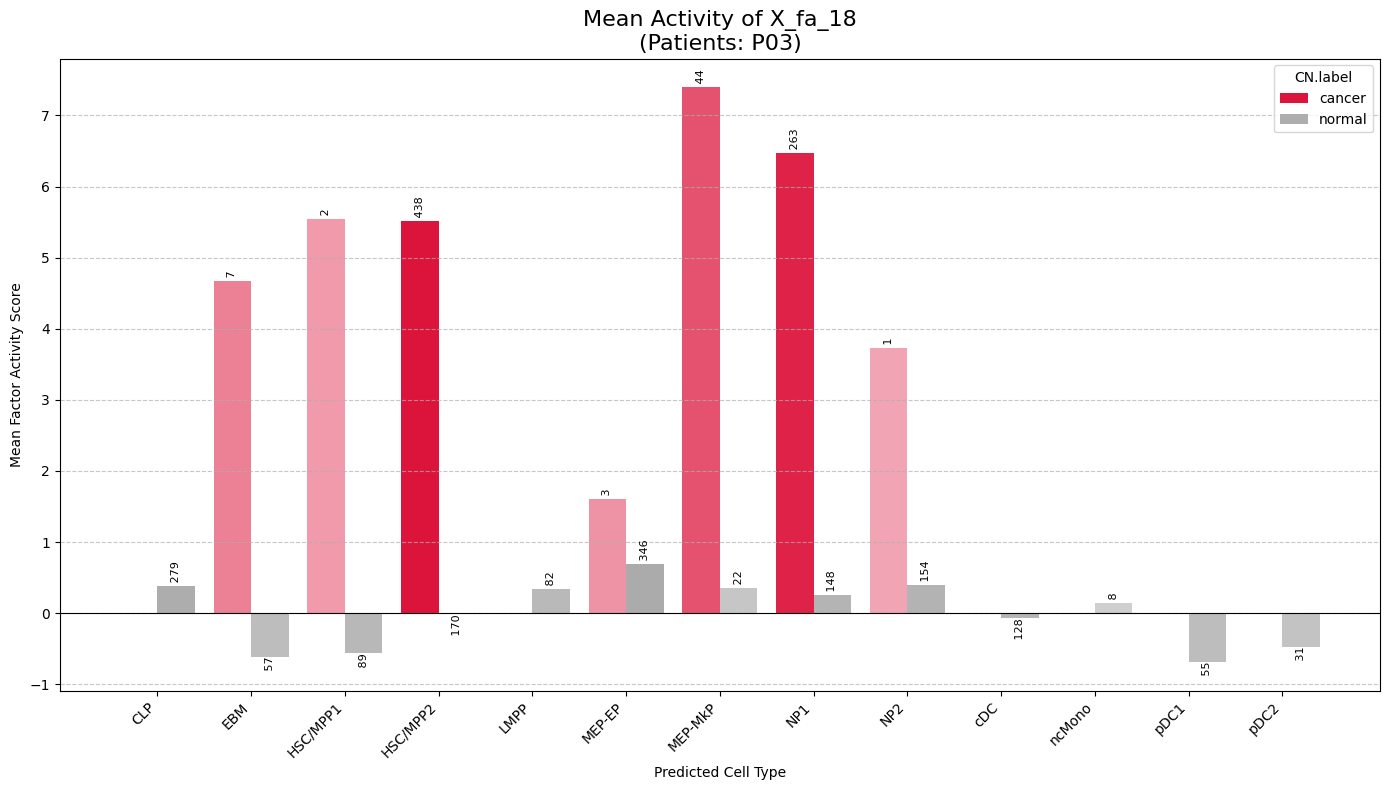


--- Running gene-level analysis for X_fa_18 ---

-- Pathway: HALLMARK_P53_PATHWAY --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_P53_PATHWAY' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 67 leading-edge genes for X_fa_18.
  -> Found 67 leading-edge genes.


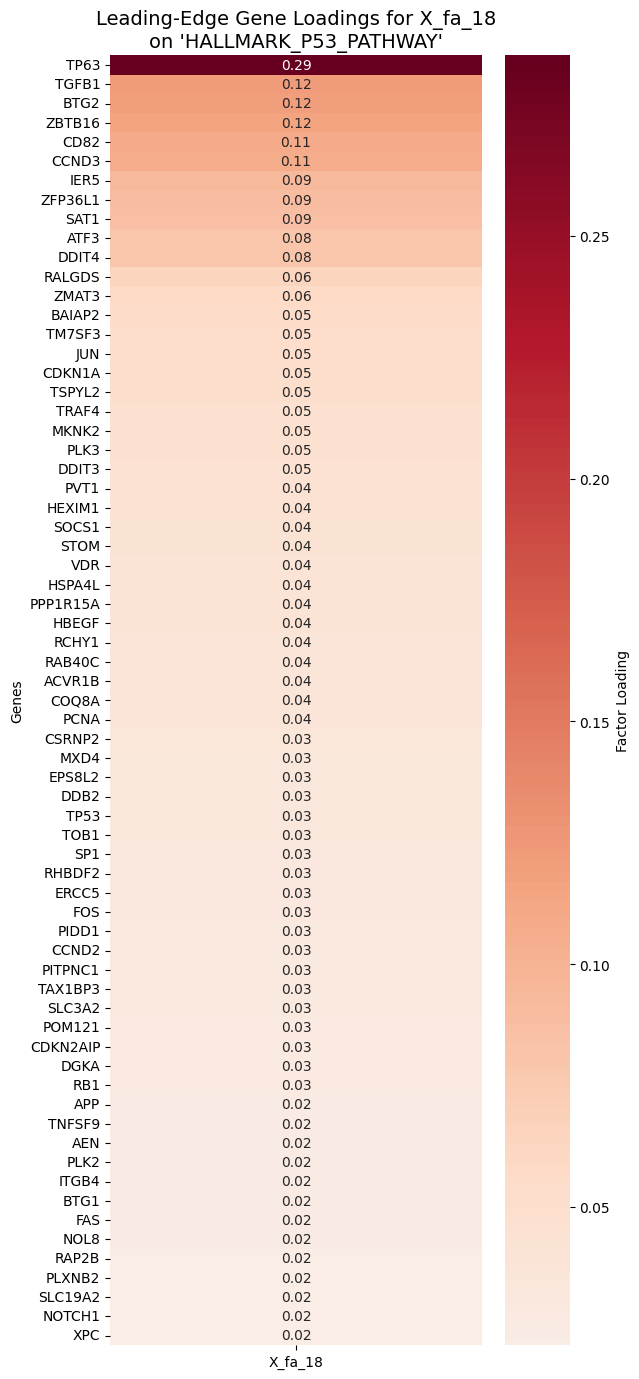

--- Top 5 Positive-Loading Genes ---
  - CD82: 0.1093
  - ZBTB16: 0.1155
  - BTG2: 0.1192
  - TGFB1: 0.1227
  - TP63: 0.2872


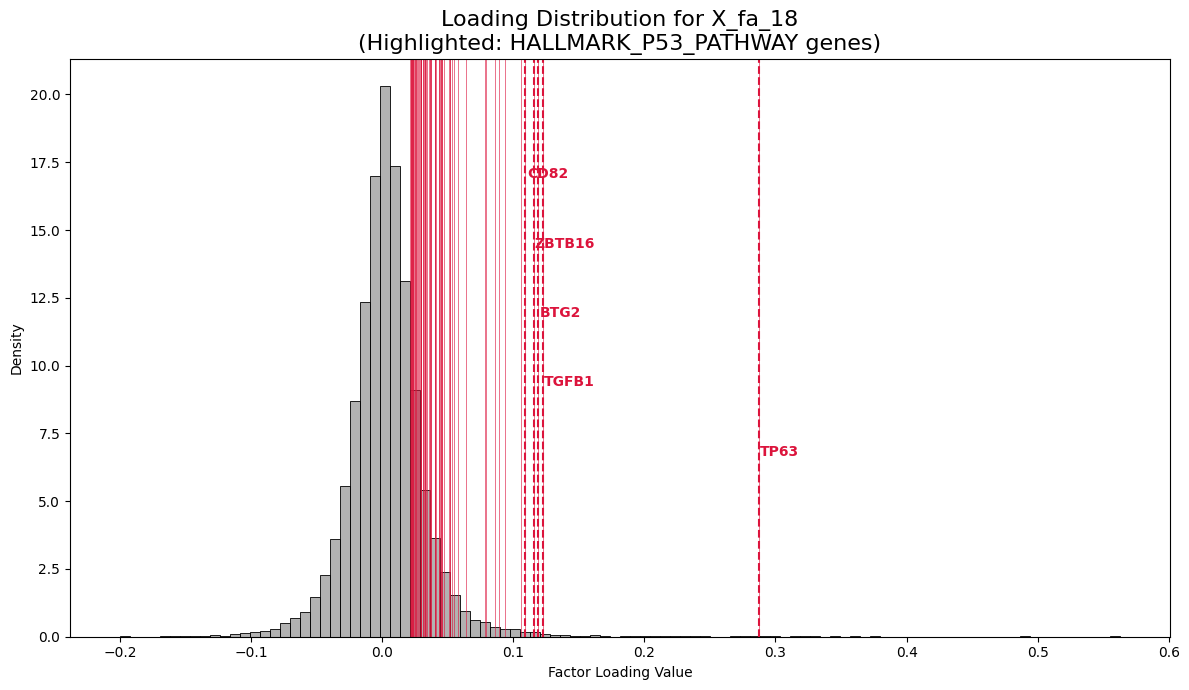


-- Pathway: HALLMARK_UV_RESPONSE_UP --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_UV_RESPONSE_UP' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 54 leading-edge genes for X_fa_18.
  -> Found 54 leading-edge genes.


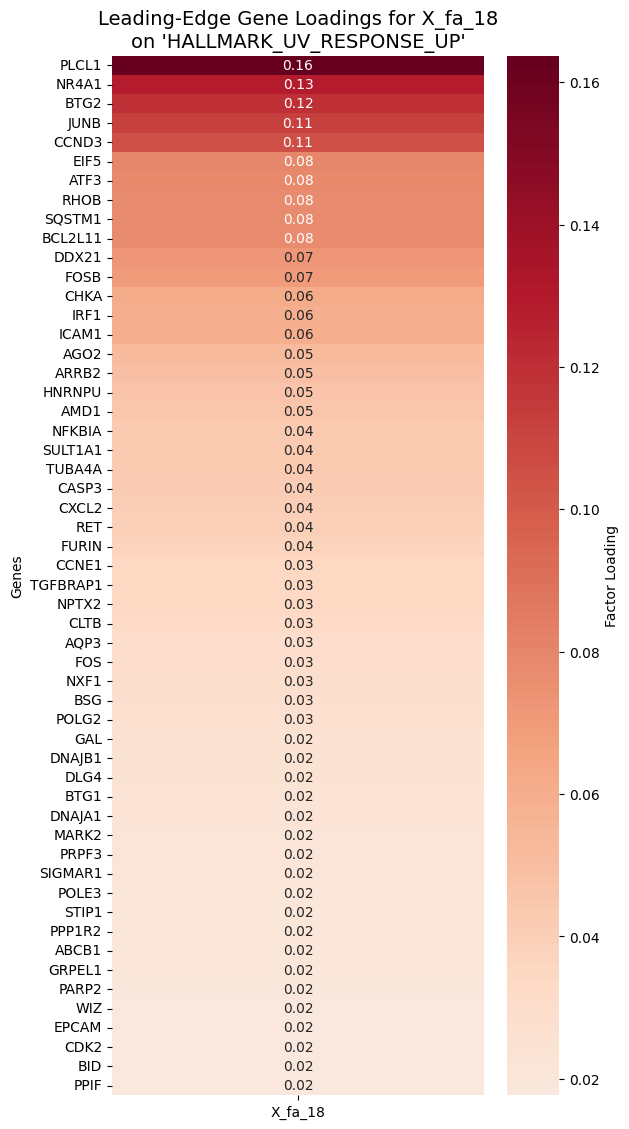

--- Top 5 Positive-Loading Genes ---
  - CCND3: 0.1060
  - JUNB: 0.1115
  - BTG2: 0.1192
  - NR4A1: 0.1282
  - PLCL1: 0.1637


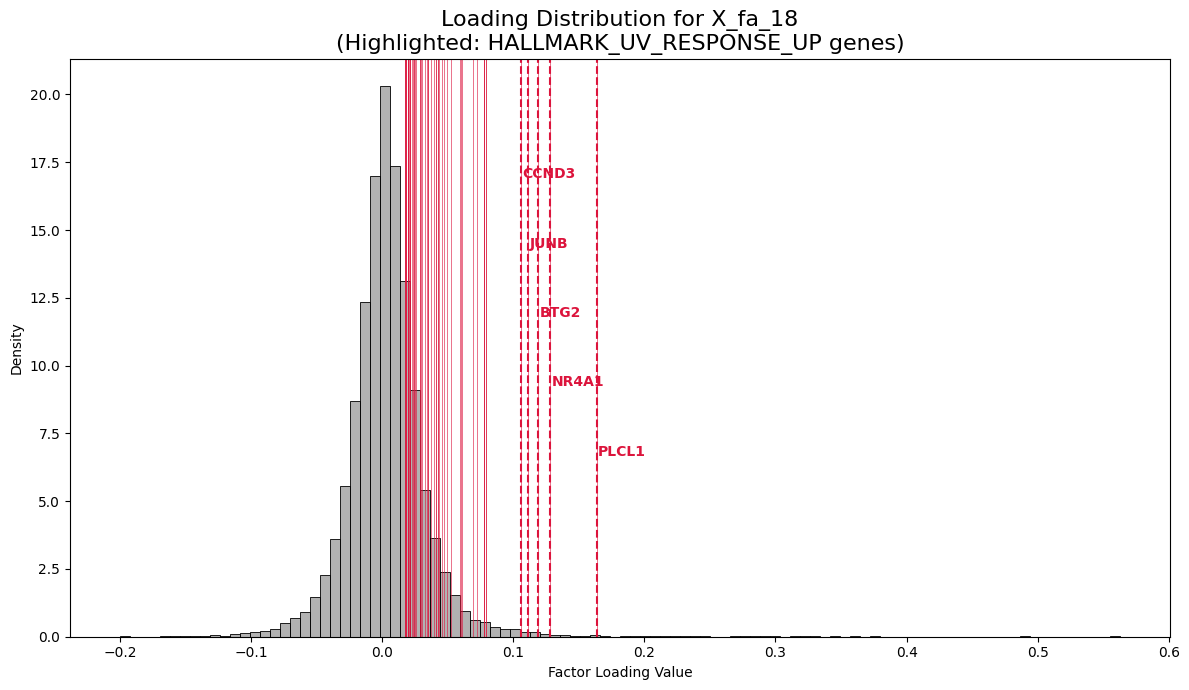


-- Pathway: HALLMARK_TNFA_SIGNALING_VIA_NFKB --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_TNFA_SIGNALING_VIA_NFKB' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 63 leading-edge genes for X_fa_18.
  -> Found 63 leading-edge genes.


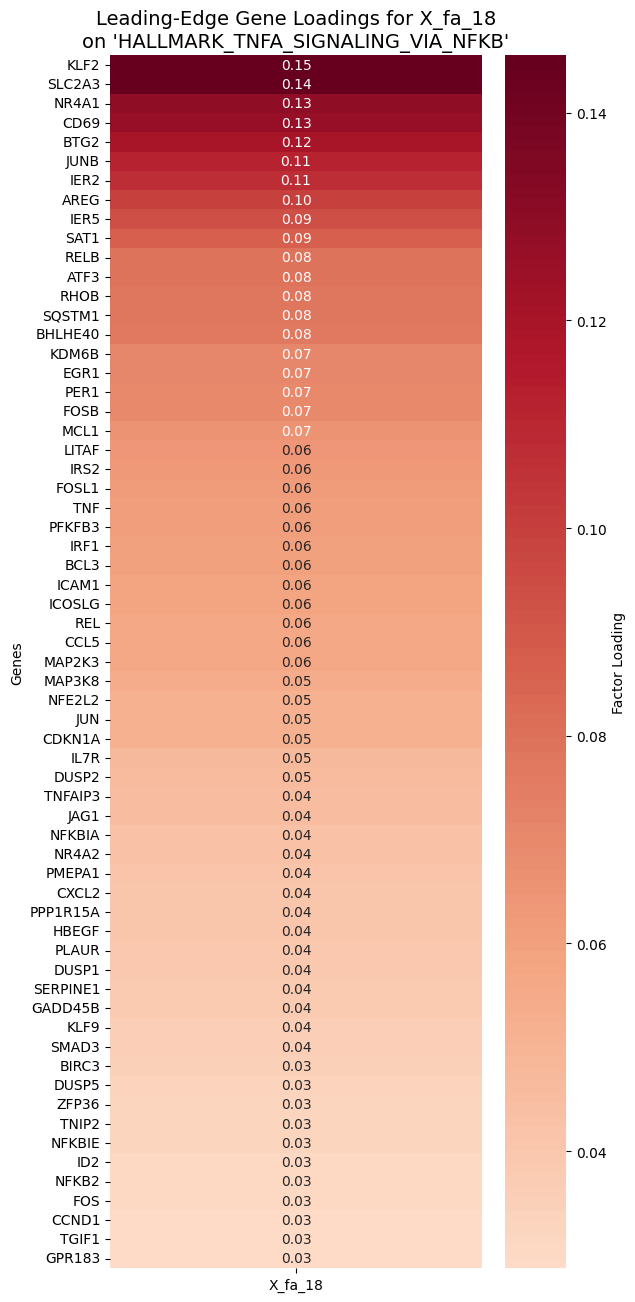

--- Top 5 Positive-Loading Genes ---
  - BTG2: 0.1192
  - CD69: 0.1261
  - NR4A1: 0.1282
  - SLC2A3: 0.1444
  - KLF2: 0.1455


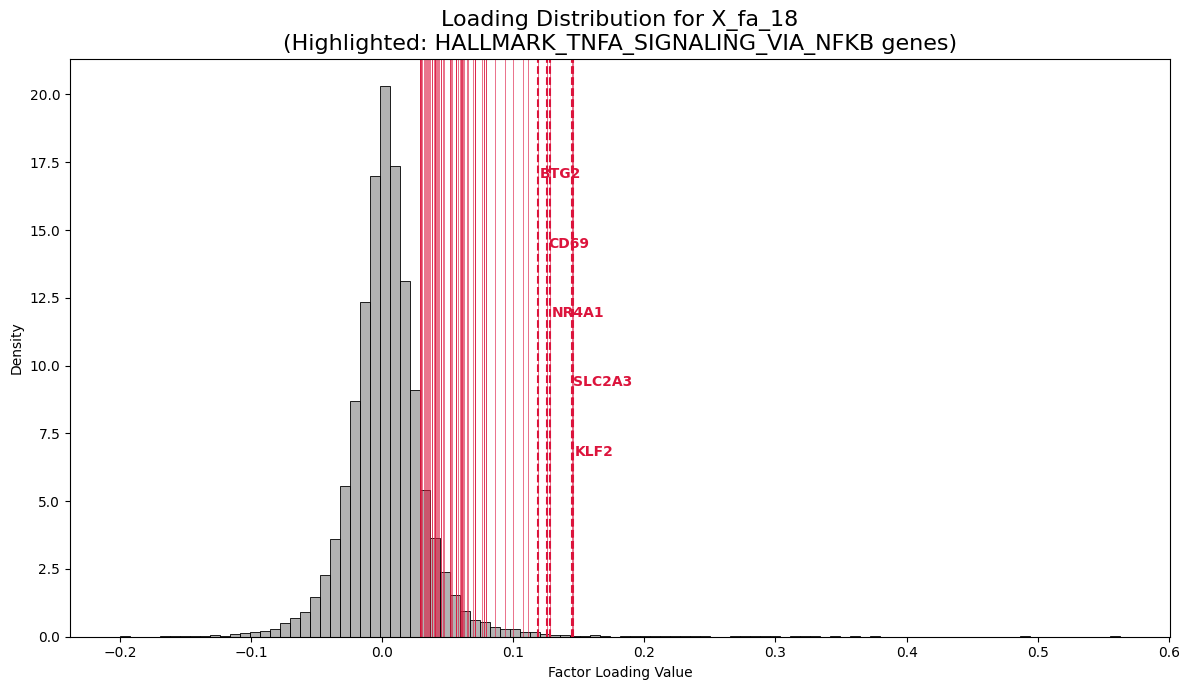


-- Pathway: HALLMARK_MYC_TARGETS_V2 --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_MYC_TARGETS_V2' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 33 leading-edge genes for X_fa_18.
  -> Found 33 leading-edge genes.


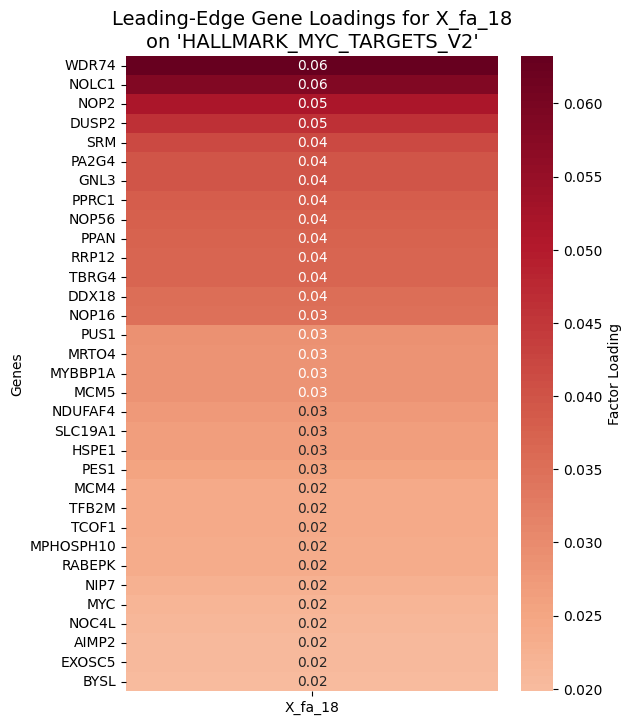

--- Top 5 Positive-Loading Genes ---
  - SRM: 0.0419
  - DUSP2: 0.0462
  - NOP2: 0.0517
  - NOLC1: 0.0582
  - WDR74: 0.0632


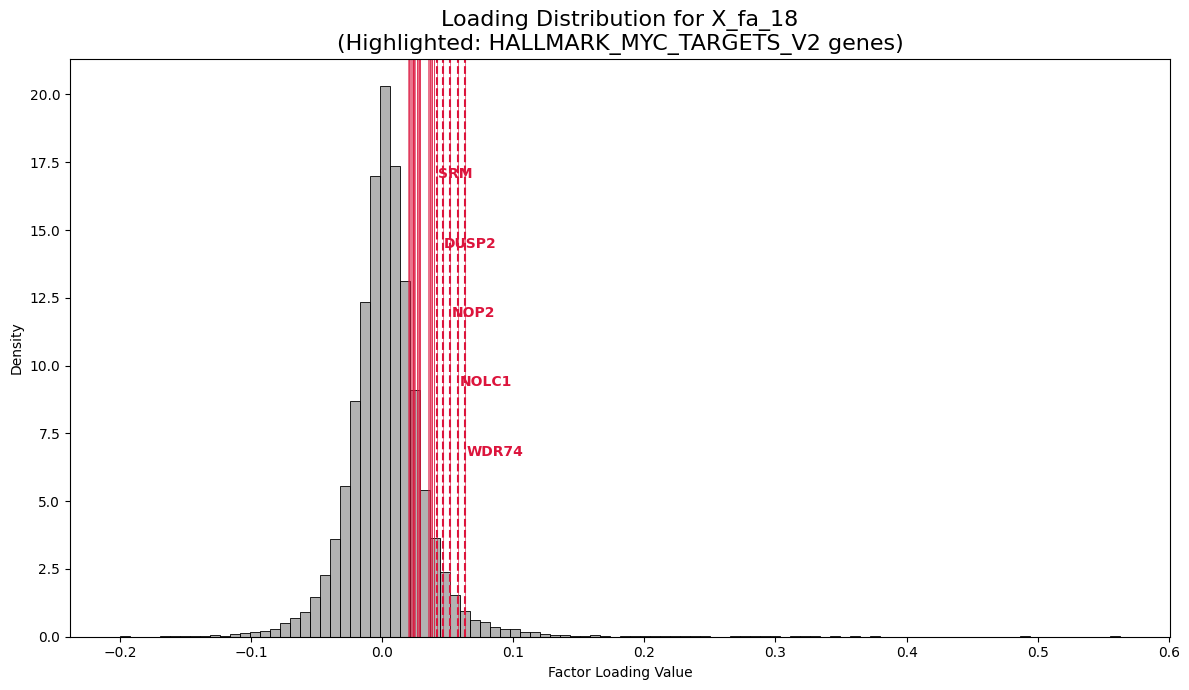


-- Pathway: HALLMARK_G2M_CHECKPOINT --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_G2M_CHECKPOINT' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 55 leading-edge genes for X_fa_18.
  -> Found 55 leading-edge genes.


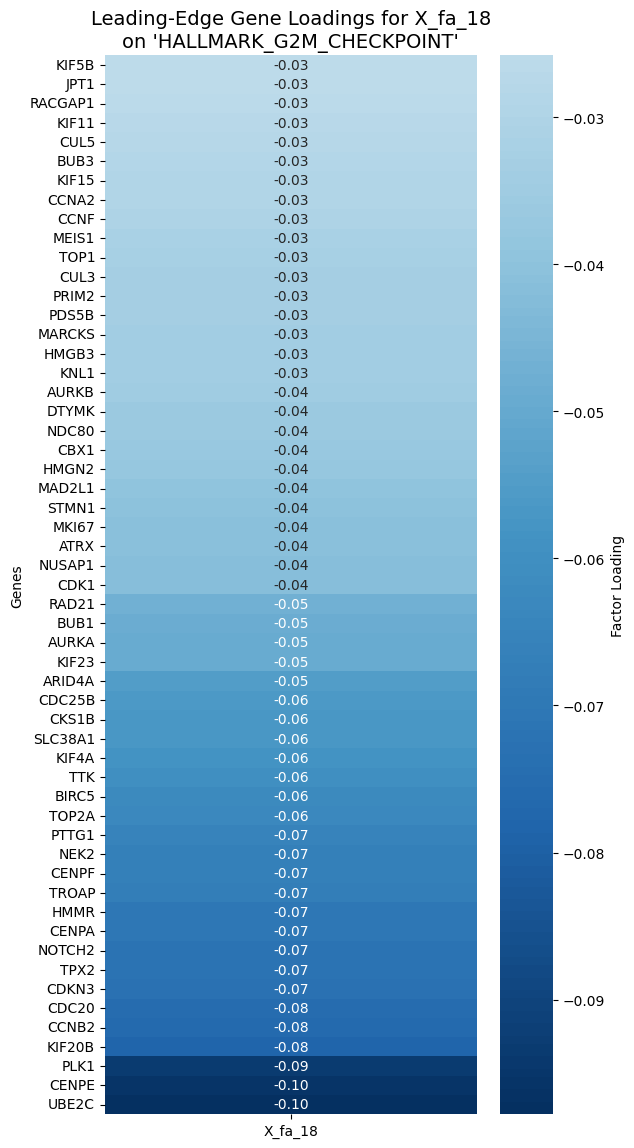

--- Top 5 Negative-Loading Genes ---
  - UBE2C: -0.0978
  - CENPE: -0.0957
  - PLK1: -0.0937
  - KIF20B: -0.0779
  - CCNB2: -0.0756


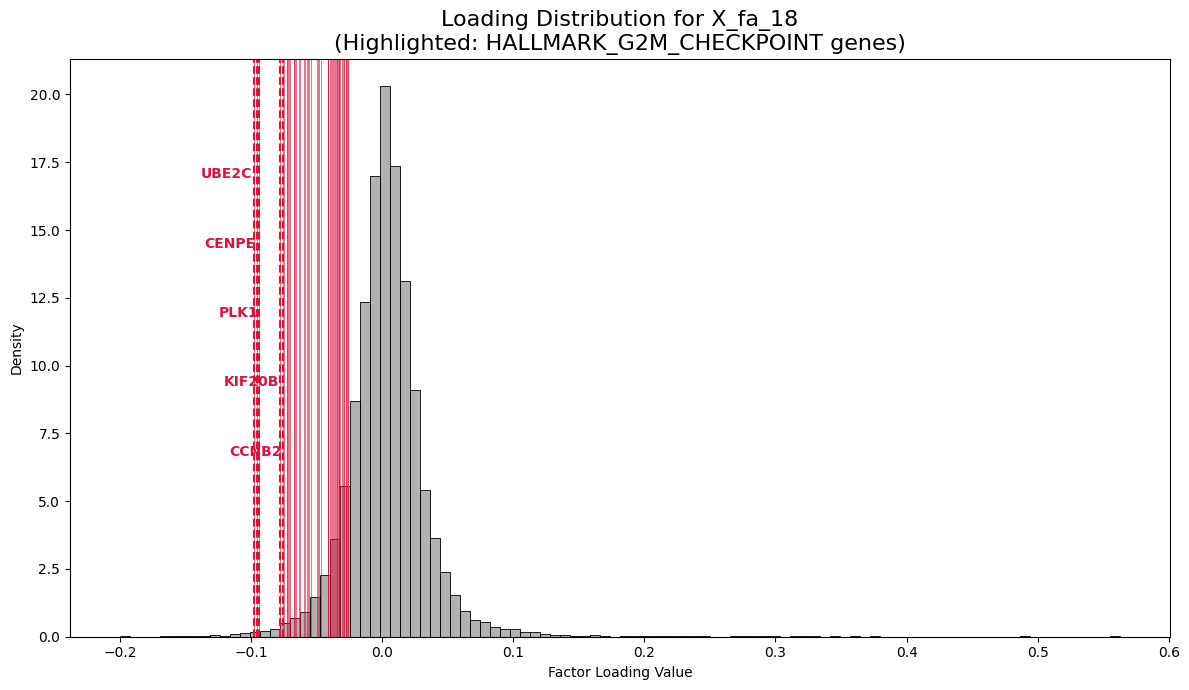


-- Pathway: HALLMARK_UV_RESPONSE_DN --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_UV_RESPONSE_DN' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 35 leading-edge genes for X_fa_18.
  -> Found 35 leading-edge genes.


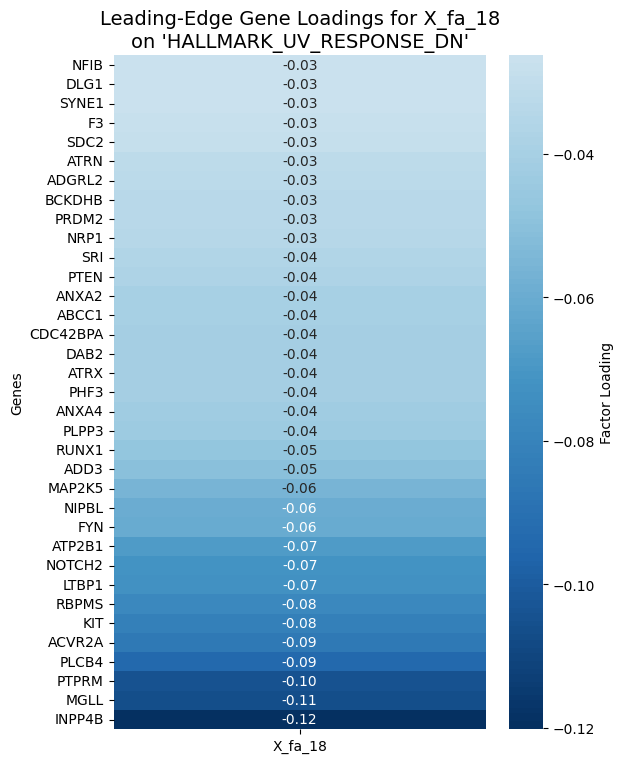

--- Top 5 Negative-Loading Genes ---
  - INPP4B: -0.1202
  - MGLL: -0.1059
  - PTPRM: -0.1045
  - PLCB4: -0.0940
  - ACVR2A: -0.0854


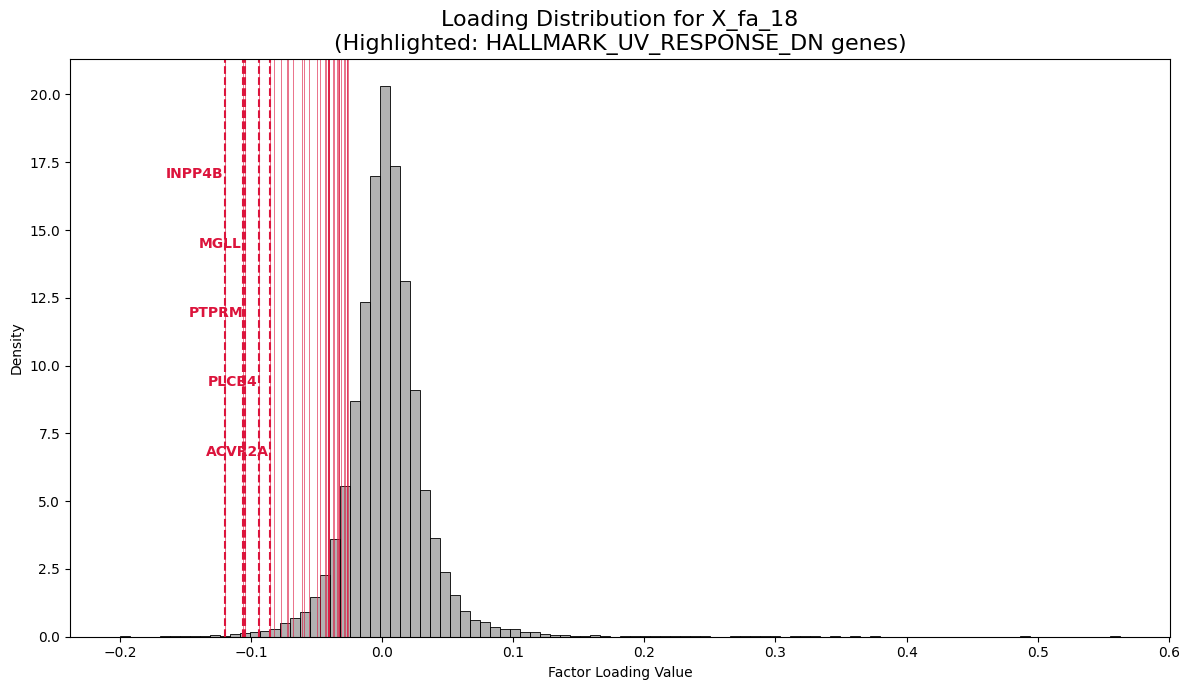


-- Pathway: HALLMARK_MITOTIC_SPINDLE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_MITOTIC_SPINDLE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 55 leading-edge genes for X_fa_18.
  -> Found 55 leading-edge genes.


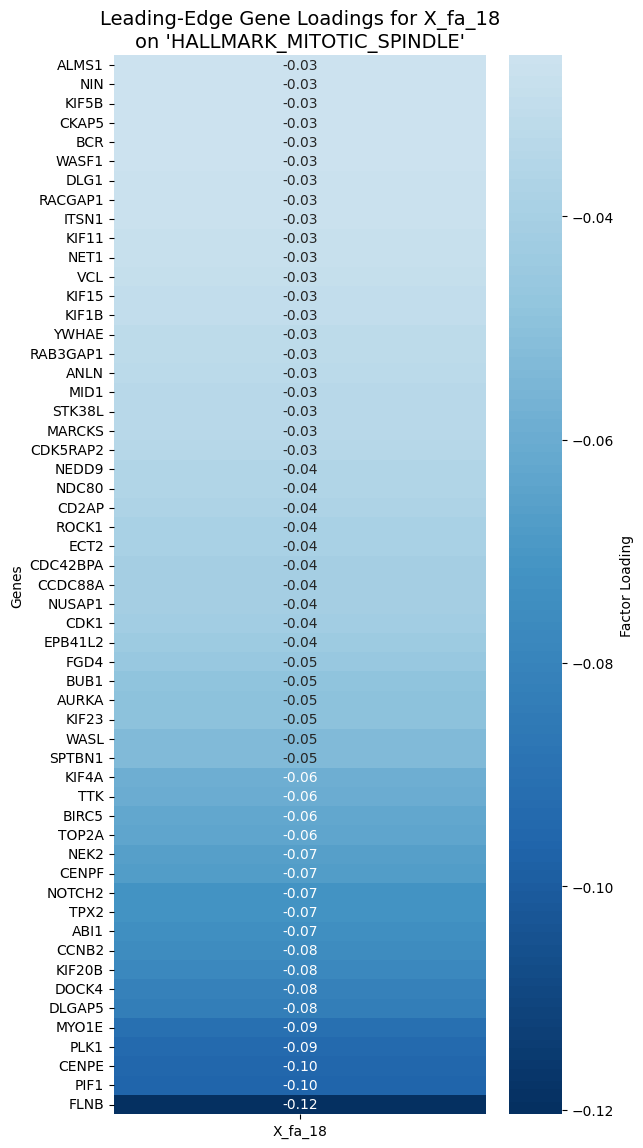

--- Top 5 Negative-Loading Genes ---
  - FLNB: -0.1204
  - PIF1: -0.0964
  - CENPE: -0.0957
  - PLK1: -0.0937
  - MYO1E: -0.0909


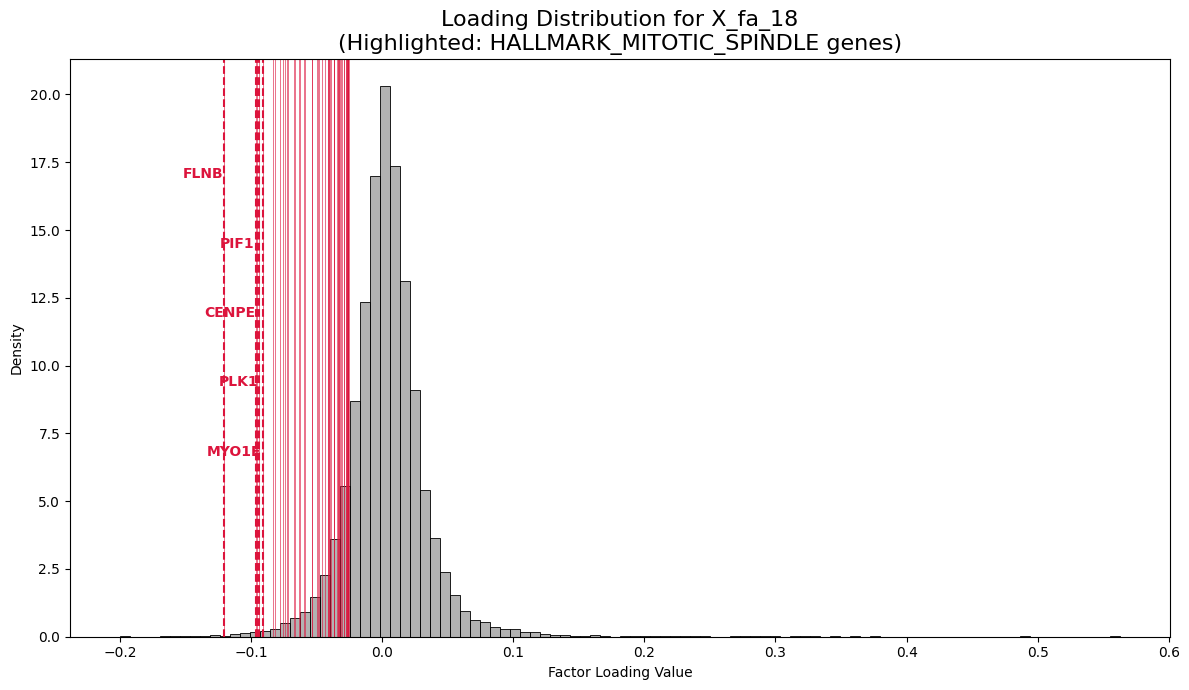


--- Analyzing Factor: X_fa_33 ---

--- Plotting activity for X_fa_33 in patients: P09, P13 ---


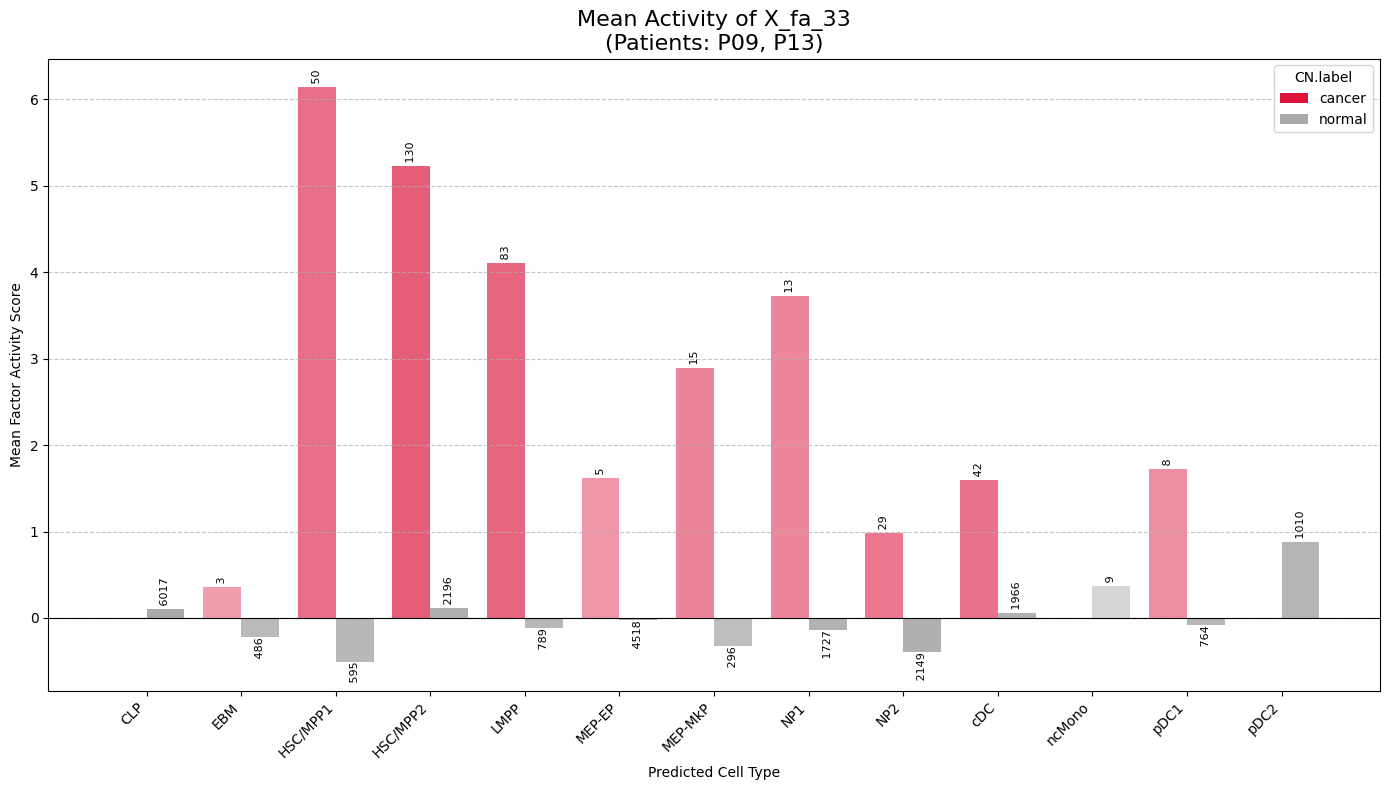


--- Running gene-level analysis for X_fa_33 ---

-- Pathway: HALLMARK_INTERFERON_ALPHA_RESPONSE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_INTERFERON_ALPHA_RESPONSE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 39 leading-edge genes for X_fa_33.
  -> Found 39 leading-edge genes.


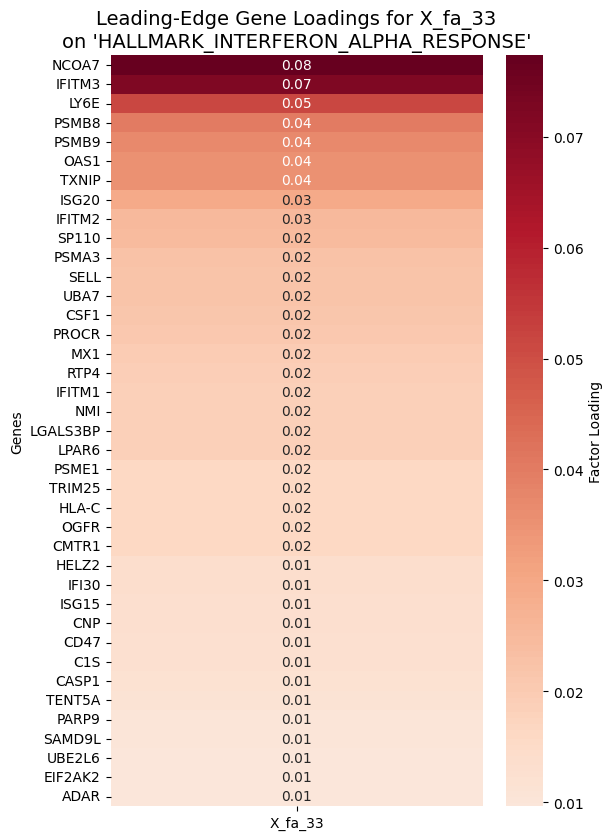

--- Top 5 Positive-Loading Genes ---
  - PSMB9: 0.0369
  - PSMB8: 0.0400
  - LY6E: 0.0517
  - IFITM3: 0.0720
  - NCOA7: 0.0773


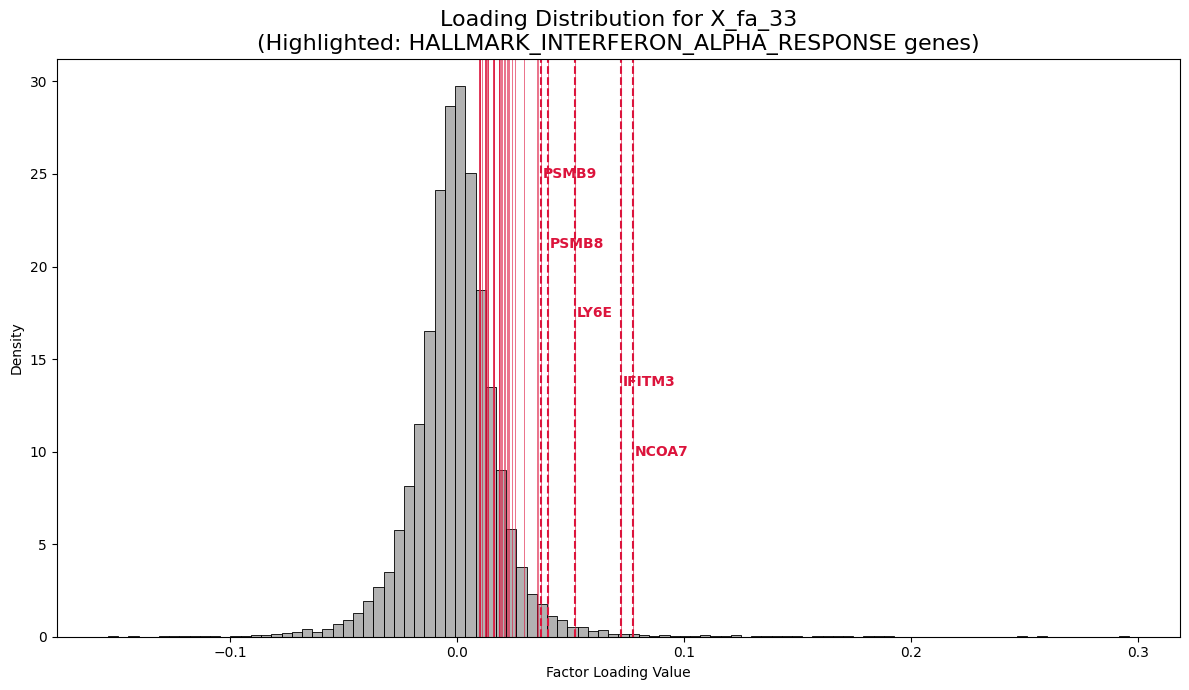


-- Pathway: HALLMARK_G2M_CHECKPOINT --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_G2M_CHECKPOINT' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 61 leading-edge genes for X_fa_33.
  -> Found 61 leading-edge genes.


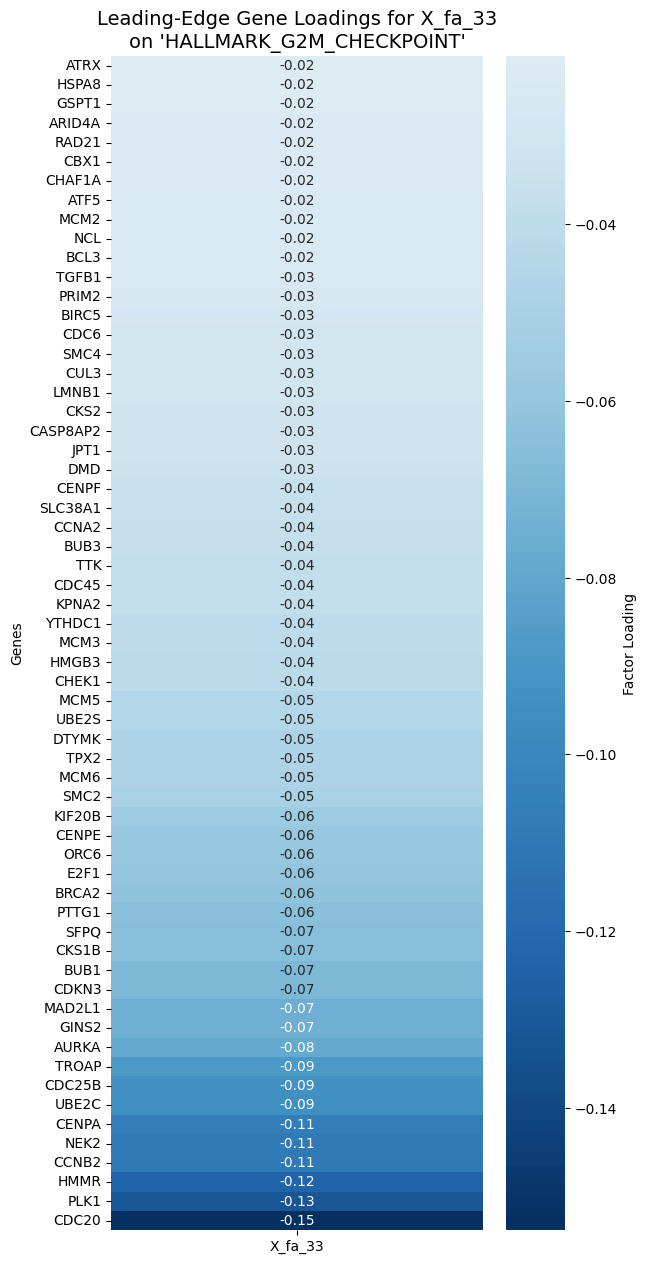

--- Top 5 Negative-Loading Genes ---
  - CDC20: -0.1538
  - PLK1: -0.1313
  - HMMR: -0.1238
  - CCNB2: -0.1092
  - NEK2: -0.1086


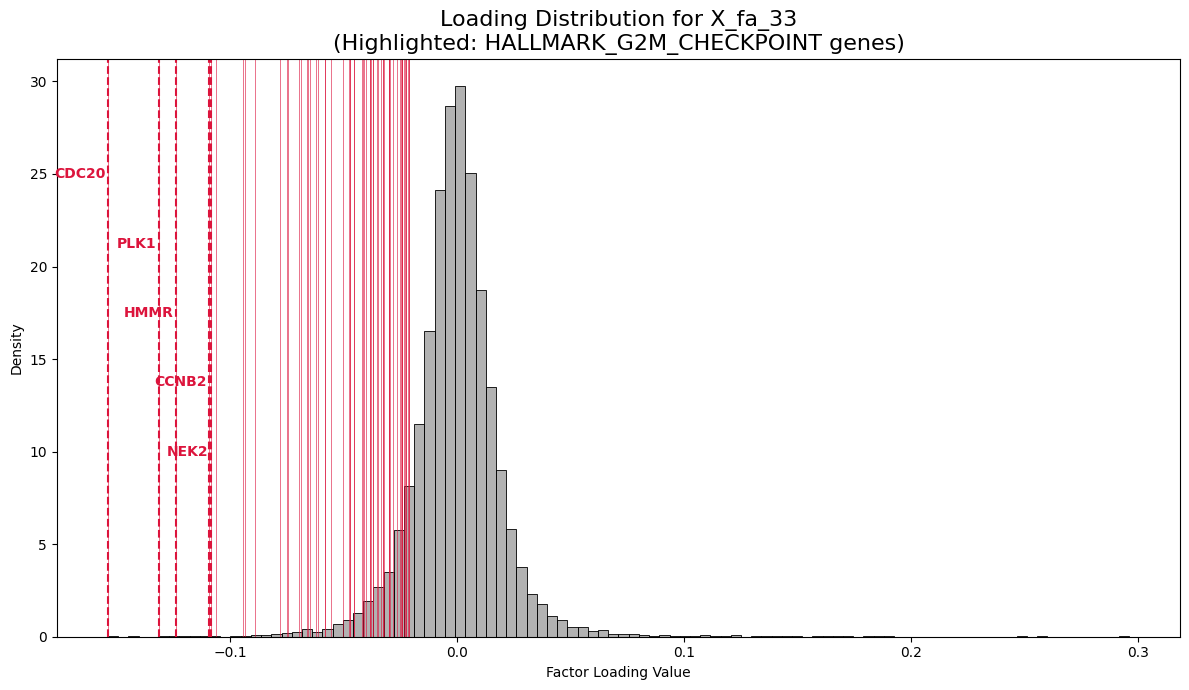


-- Pathway: HALLMARK_E2F_TARGETS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_E2F_TARGETS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 60 leading-edge genes for X_fa_33.
  -> Found 60 leading-edge genes.


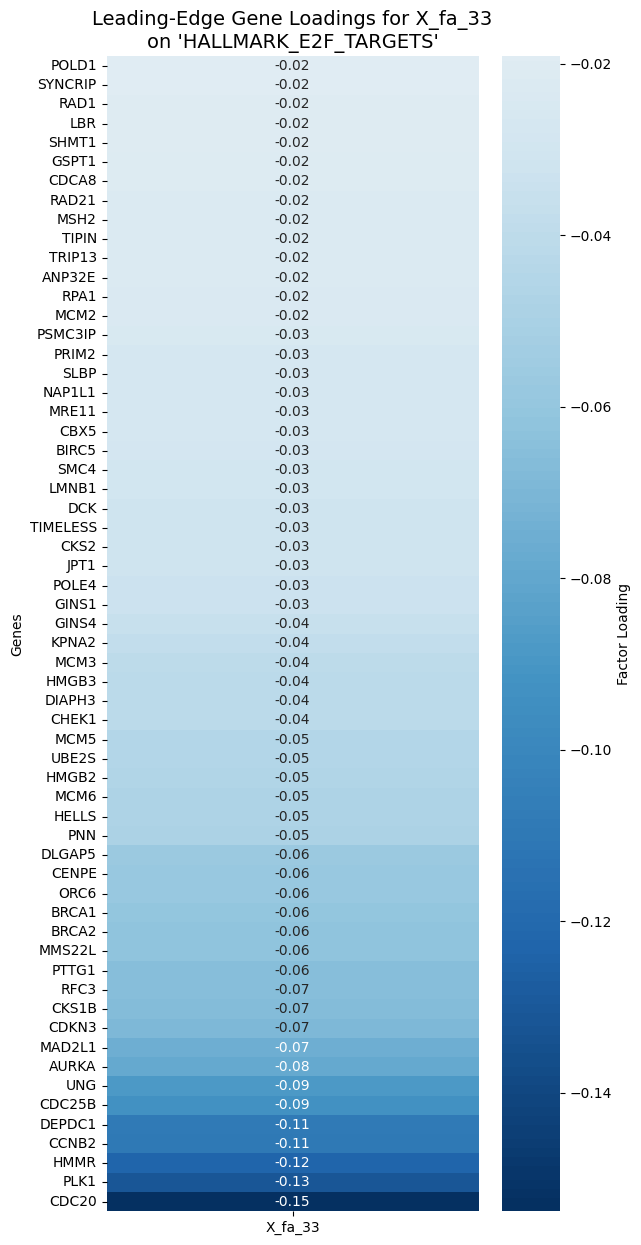

--- Top 5 Negative-Loading Genes ---
  - CDC20: -0.1538
  - PLK1: -0.1313
  - HMMR: -0.1238
  - CCNB2: -0.1092
  - DEPDC1: -0.1081


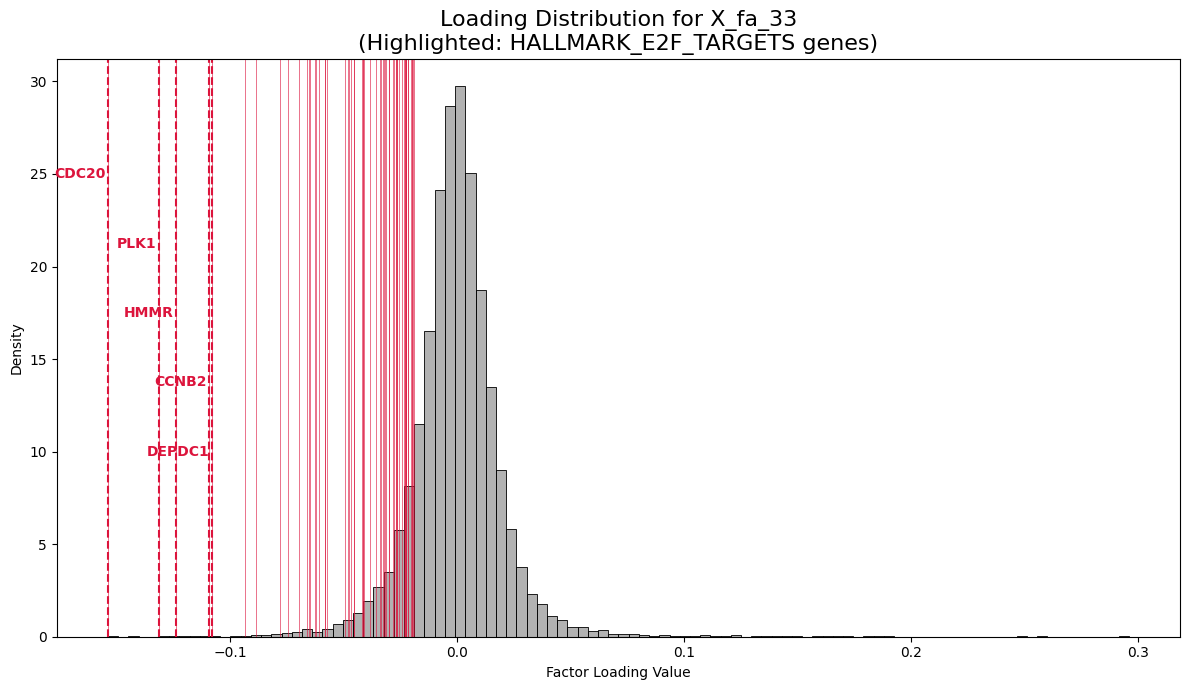


-- Pathway: HALLMARK_SPERMATOGENESIS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_SPERMATOGENESIS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 14 leading-edge genes for X_fa_33.
  -> Found 14 leading-edge genes.


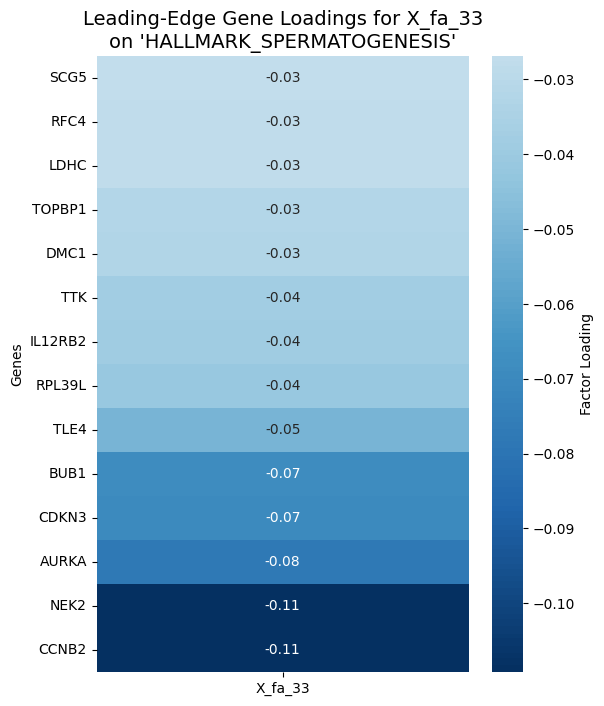

--- Top 5 Negative-Loading Genes ---
  - CCNB2: -0.1092
  - NEK2: -0.1086
  - AURKA: -0.0782
  - CDKN3: -0.0695
  - BUB1: -0.0689


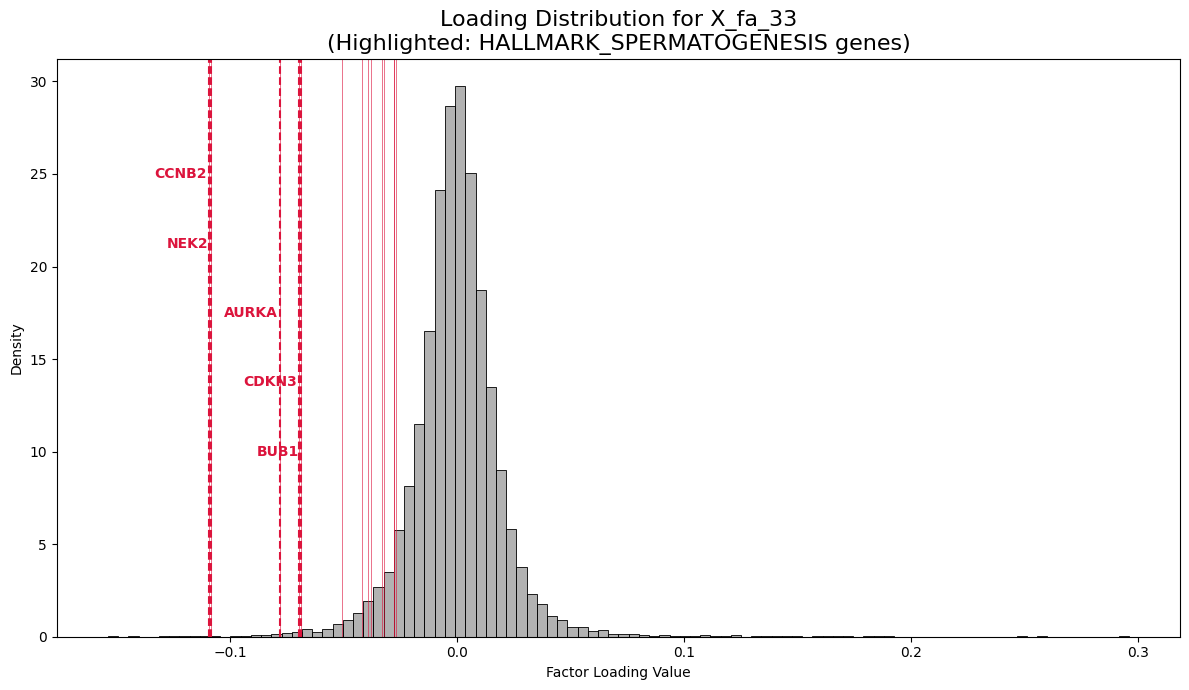


-- Pathway: HALLMARK_TNFA_SIGNALING_VIA_NFKB --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_TNFA_SIGNALING_VIA_NFKB' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 59 leading-edge genes for X_fa_33.
  -> Found 59 leading-edge genes.


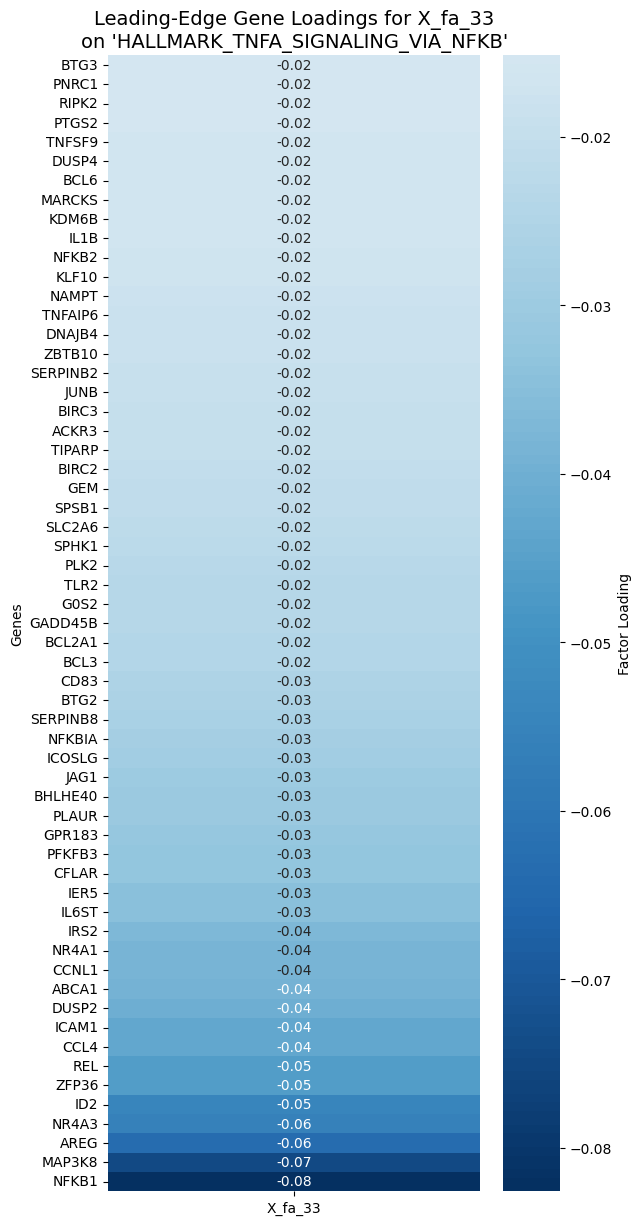

--- Top 5 Negative-Loading Genes ---
  - NFKB1: -0.0826
  - MAP3K8: -0.0743
  - AREG: -0.0637
  - NR4A3: -0.0556
  - ID2: -0.0545


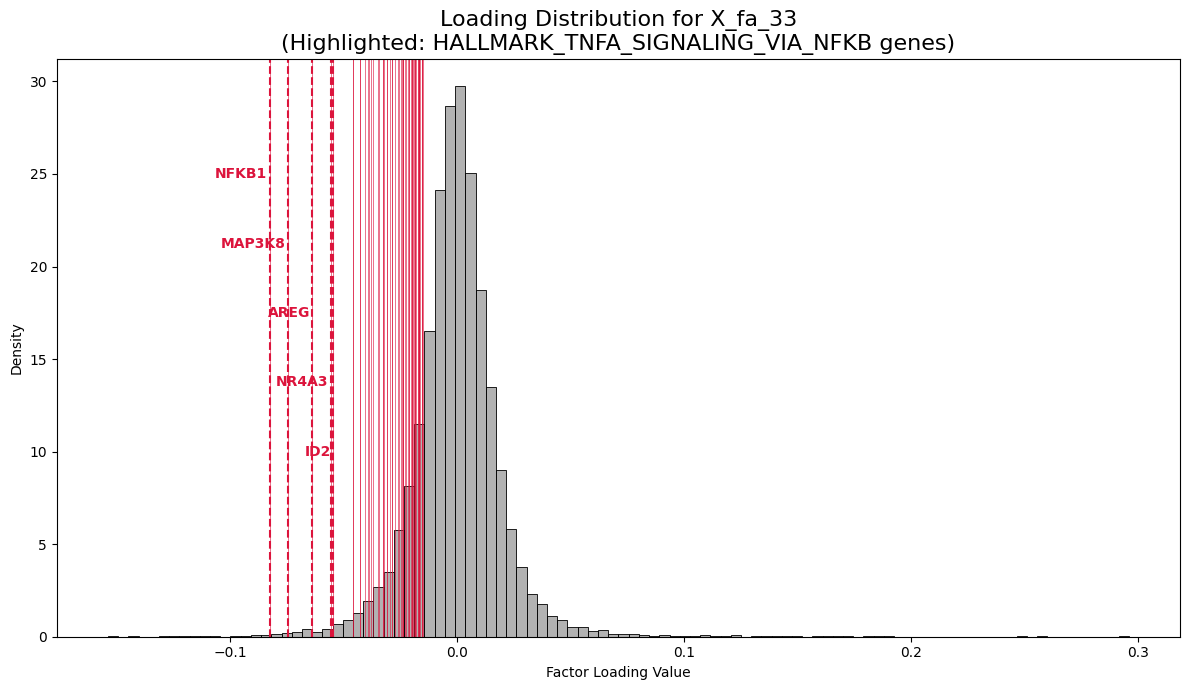


--- Analyzing Factor: X_fa_35 ---

--- Plotting activity for X_fa_35 in patients: P09 ---


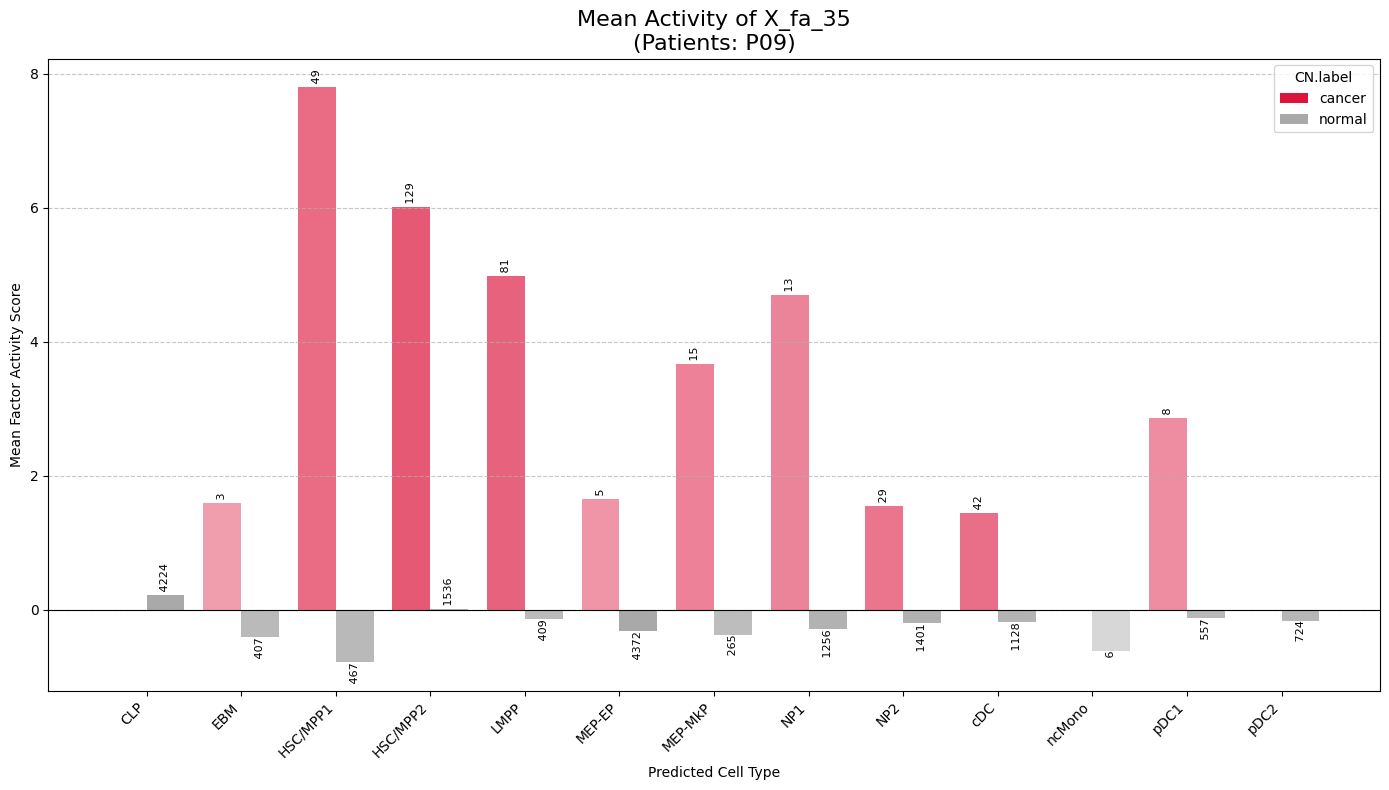


--- Running gene-level analysis for X_fa_35 ---

-- Pathway: HALLMARK_OXIDATIVE_PHOSPHORYLATION --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_OXIDATIVE_PHOSPHORYLATION' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 94 leading-edge genes for X_fa_35.
  -> Found 94 leading-edge genes.


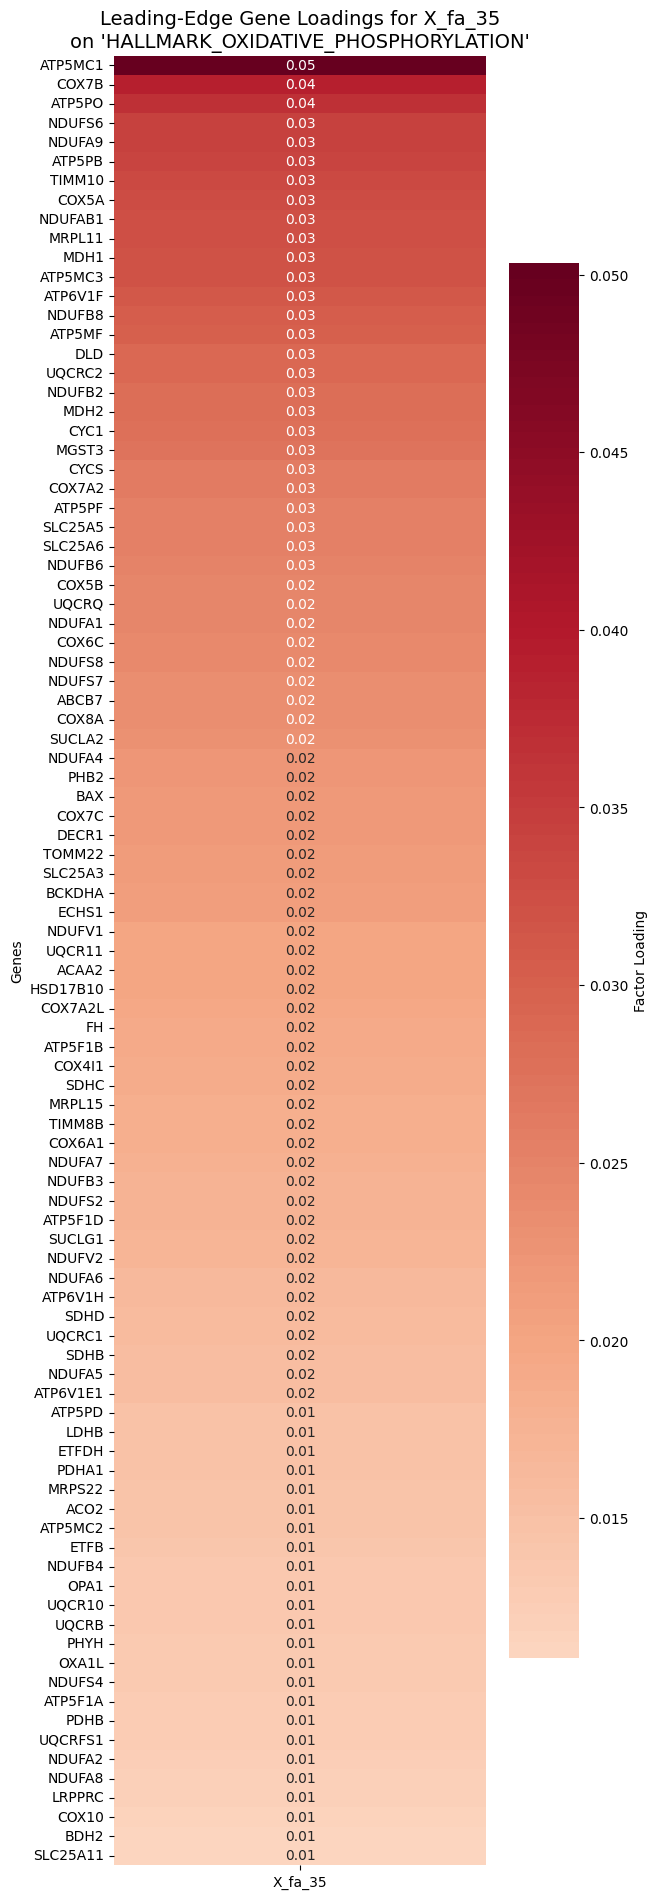

--- Top 5 Positive-Loading Genes ---
  - NDUFA9: 0.0342
  - NDUFS6: 0.0344
  - ATP5PO: 0.0369
  - COX7B: 0.0390
  - ATP5MC1: 0.0503


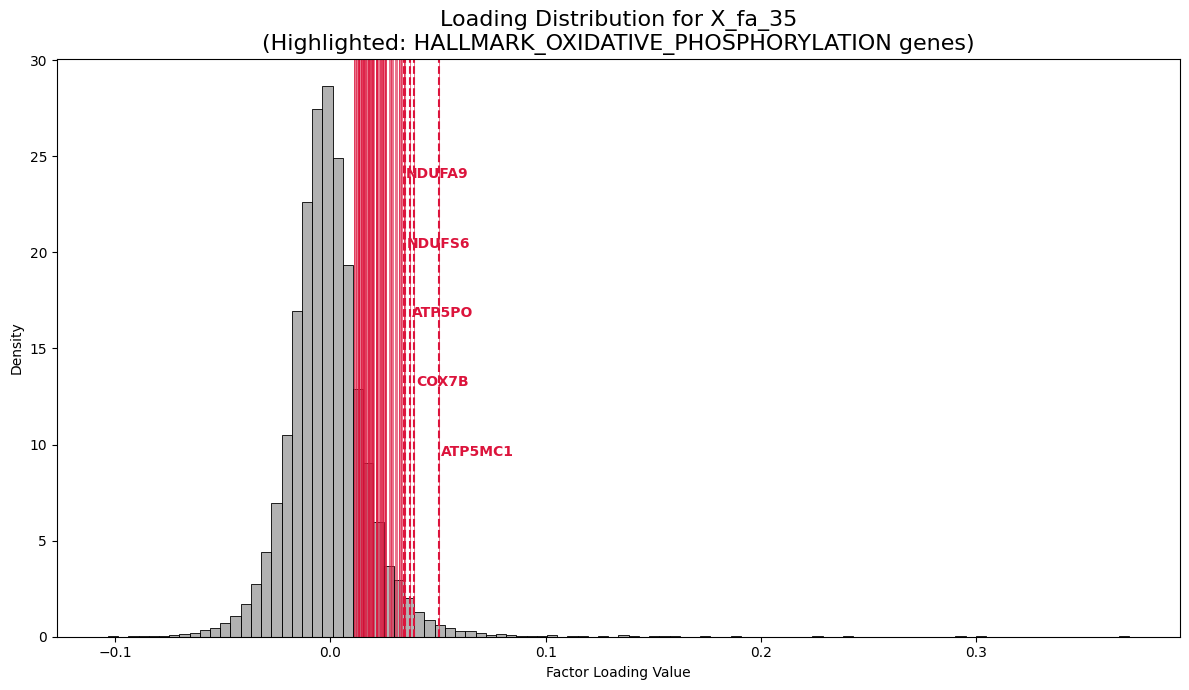


-- Pathway: HALLMARK_TNFA_SIGNALING_VIA_NFKB --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_TNFA_SIGNALING_VIA_NFKB' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 72 leading-edge genes for X_fa_35.
  -> Found 72 leading-edge genes.


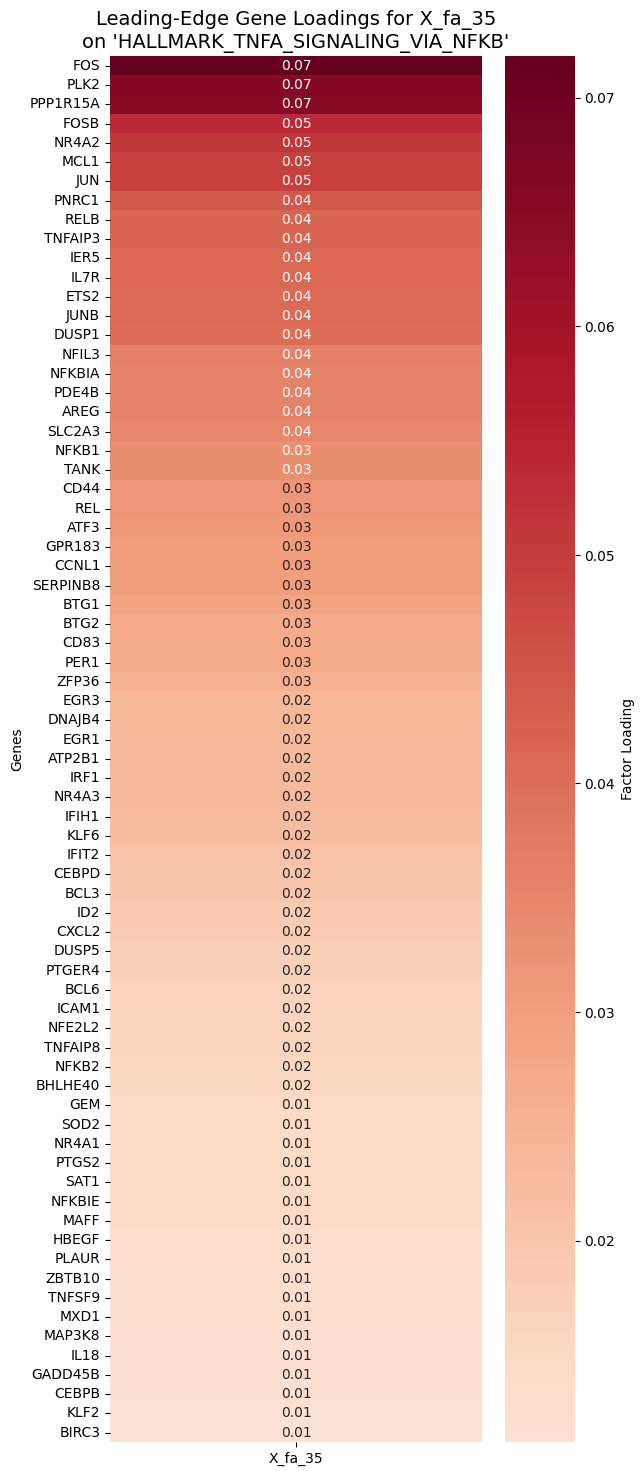

--- Top 5 Positive-Loading Genes ---
  - NR4A2: 0.0510
  - FOSB: 0.0535
  - PPP1R15A: 0.0651
  - PLK2: 0.0661
  - FOS: 0.0718


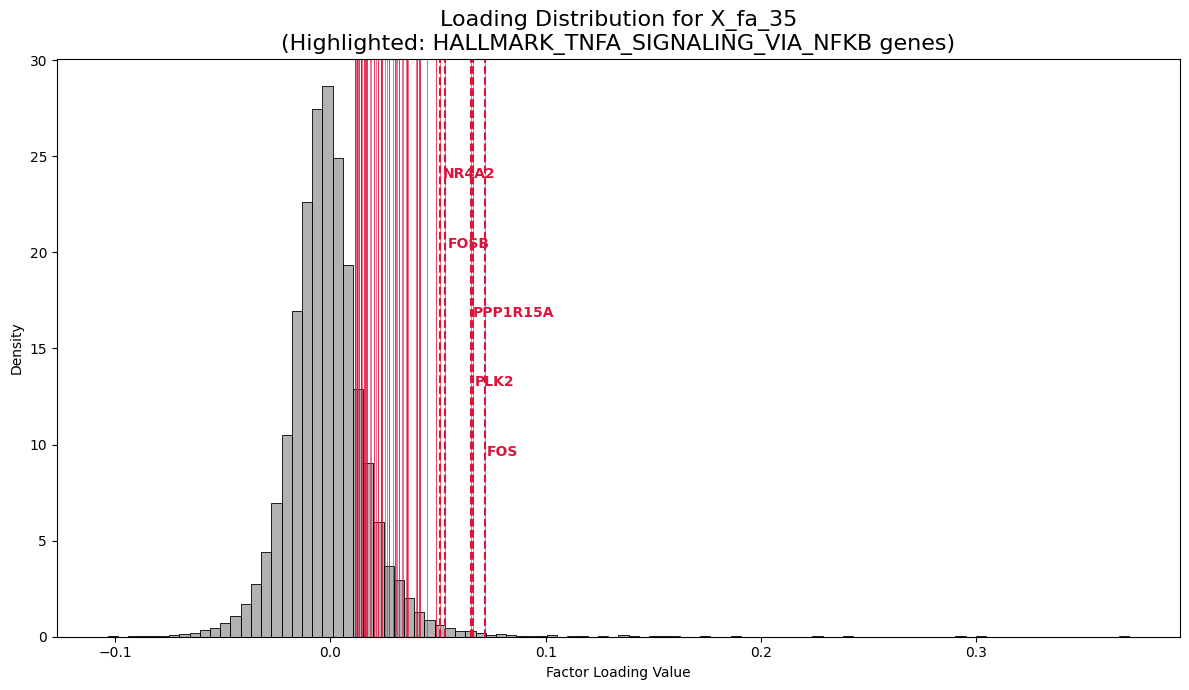


-- Pathway: HALLMARK_MYC_TARGETS_V1 --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_MYC_TARGETS_V1' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 62 leading-edge genes for X_fa_35.
  -> Found 62 leading-edge genes.


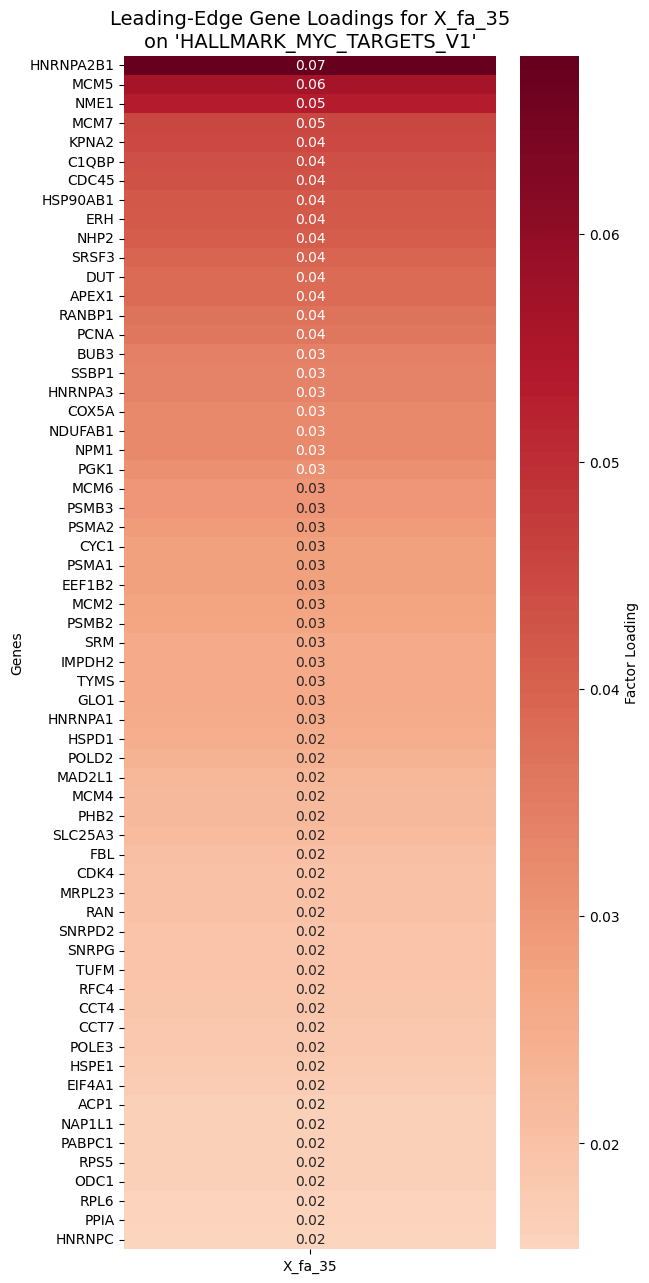

--- Top 5 Positive-Loading Genes ---
  - KPNA2: 0.0448
  - MCM7: 0.0453
  - NME1: 0.0532
  - MCM5: 0.0564
  - HNRNPA2B1: 0.0679


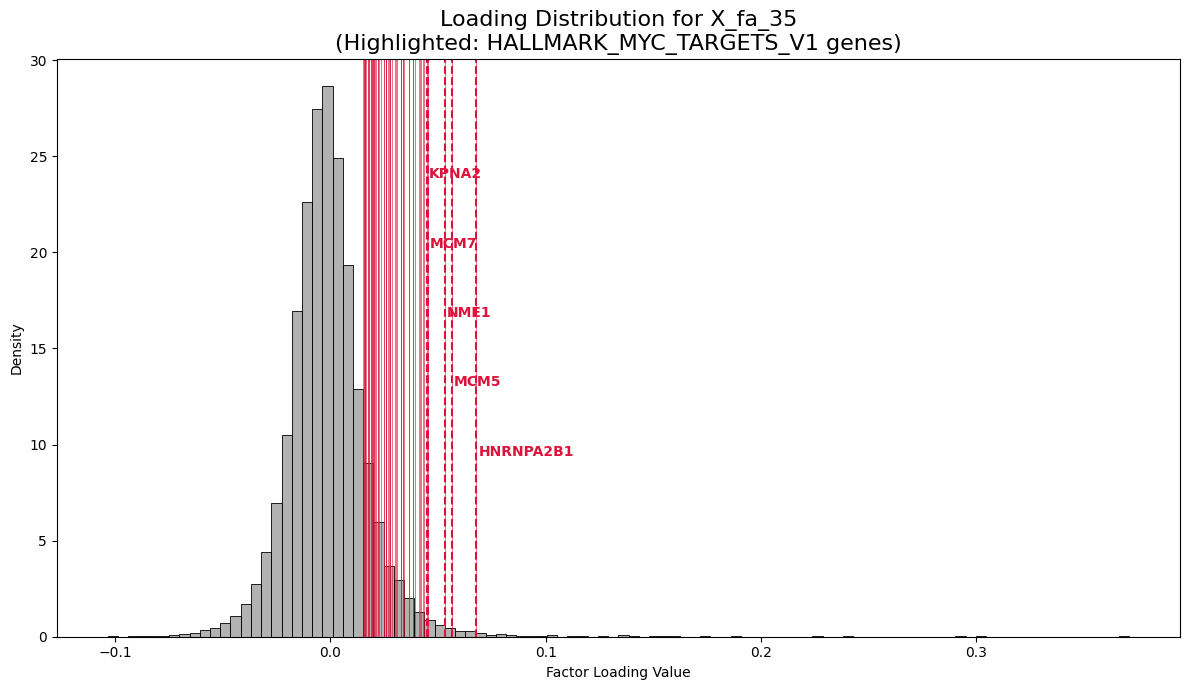


-- Pathway: HALLMARK_E2F_TARGETS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_E2F_TARGETS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 55 leading-edge genes for X_fa_35.
  -> Found 55 leading-edge genes.


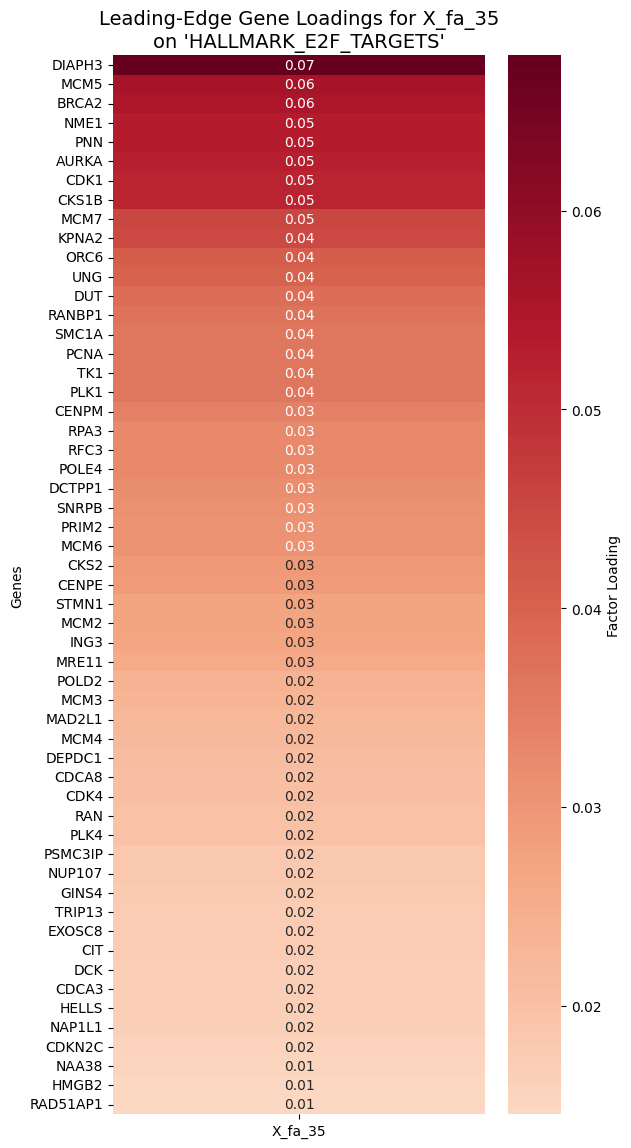

--- Top 5 Positive-Loading Genes ---
  - PNN: 0.0531
  - NME1: 0.0532
  - BRCA2: 0.0554
  - MCM5: 0.0564
  - DIAPH3: 0.0678


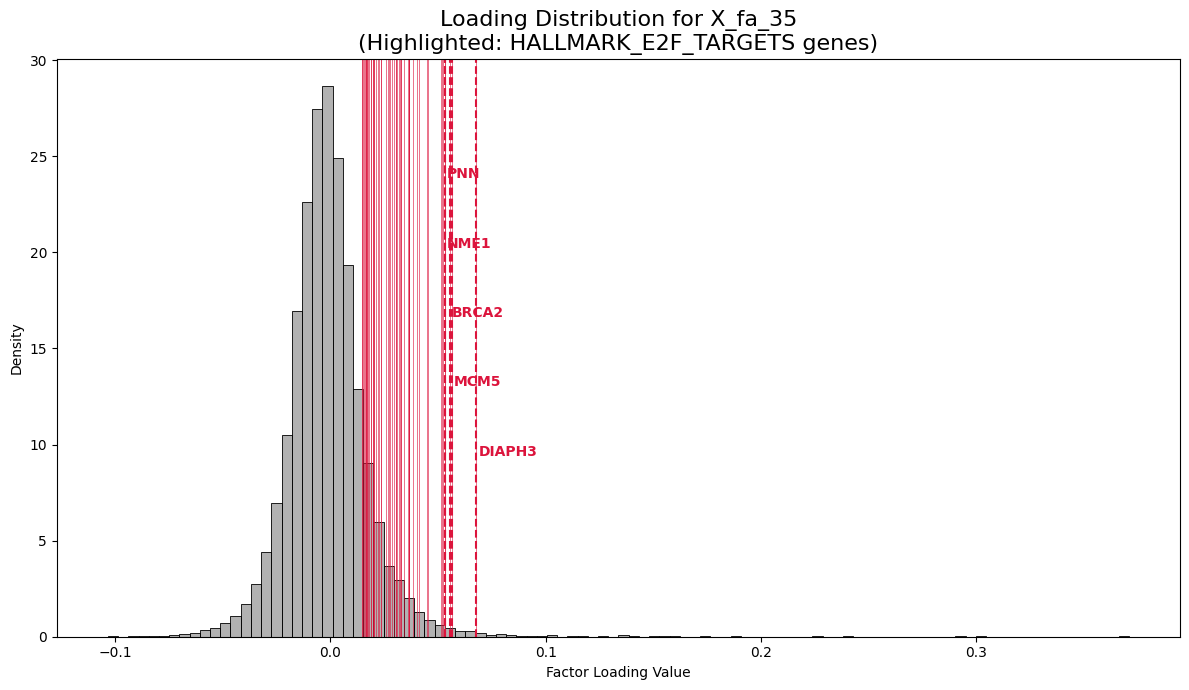


-- Pathway: HALLMARK_ESTROGEN_RESPONSE_EARLY --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_ESTROGEN_RESPONSE_EARLY' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 50 leading-edge genes for X_fa_35.
  -> Found 50 leading-edge genes.


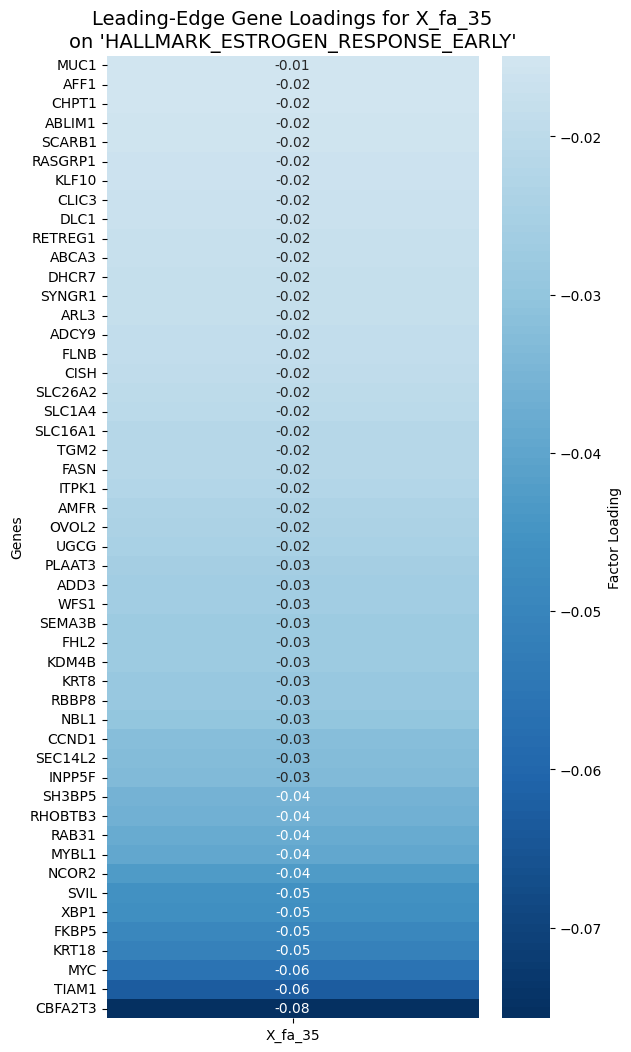

--- Top 5 Negative-Loading Genes ---
  - CBFA2T3: -0.0757
  - TIAM1: -0.0628
  - MYC: -0.0556
  - KRT18: -0.0510
  - FKBP5: -0.0493


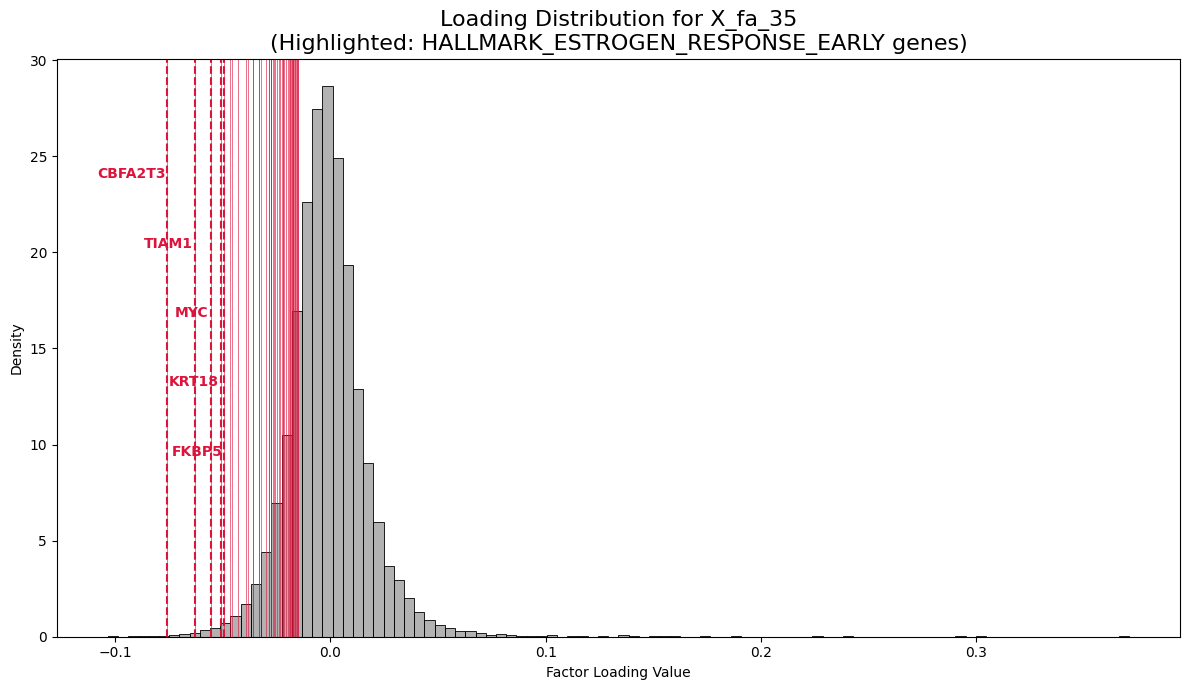


-- Pathway: HALLMARK_APICAL_JUNCTION --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_APICAL_JUNCTION' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 51 leading-edge genes for X_fa_35.
  -> Found 51 leading-edge genes.


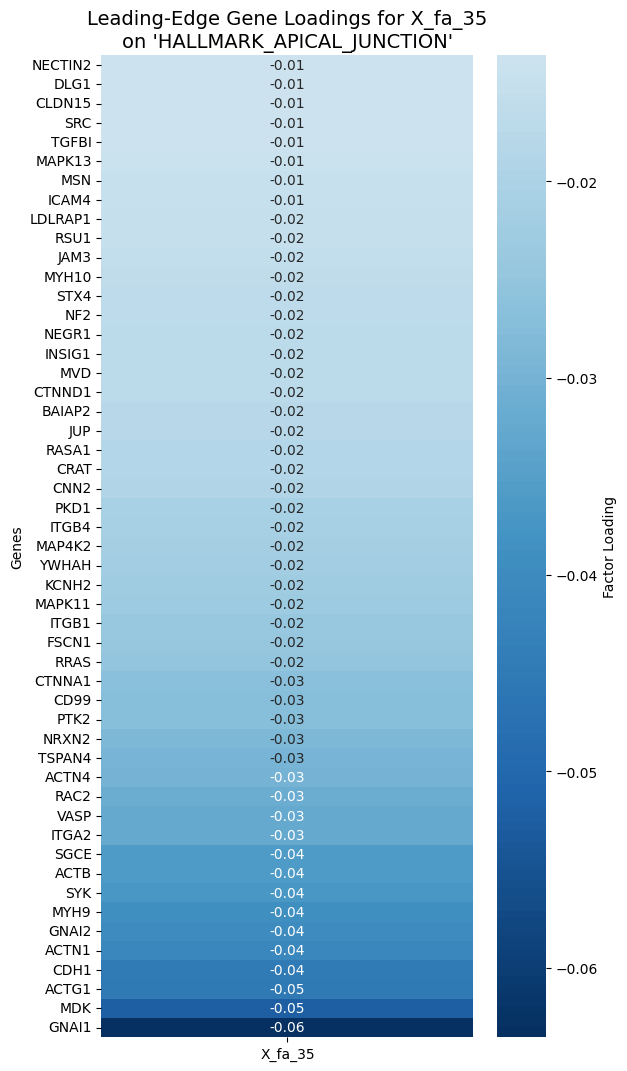

--- Top 5 Negative-Loading Genes ---
  - GNAI1: -0.0635
  - MDK: -0.0523
  - ACTG1: -0.0454
  - CDH1: -0.0449
  - ACTN1: -0.0413


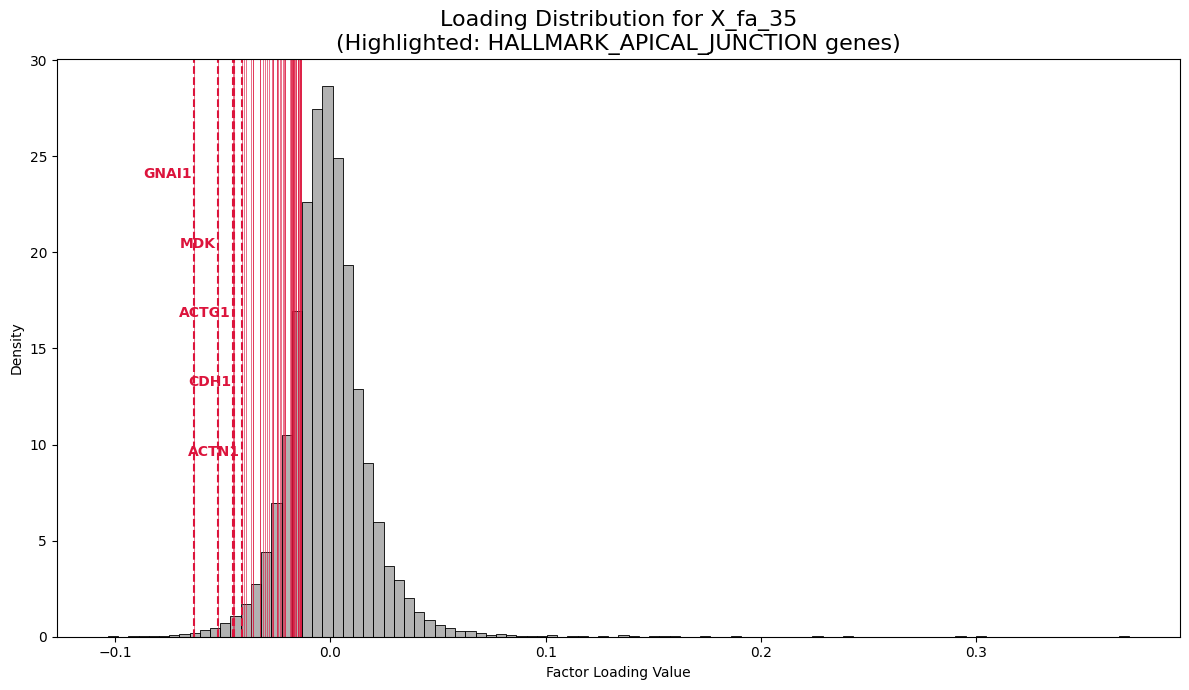


-- Pathway: HALLMARK_CHOLESTEROL_HOMEOSTASIS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_CHOLESTEROL_HOMEOSTASIS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 19 leading-edge genes for X_fa_35.
  -> Found 19 leading-edge genes.


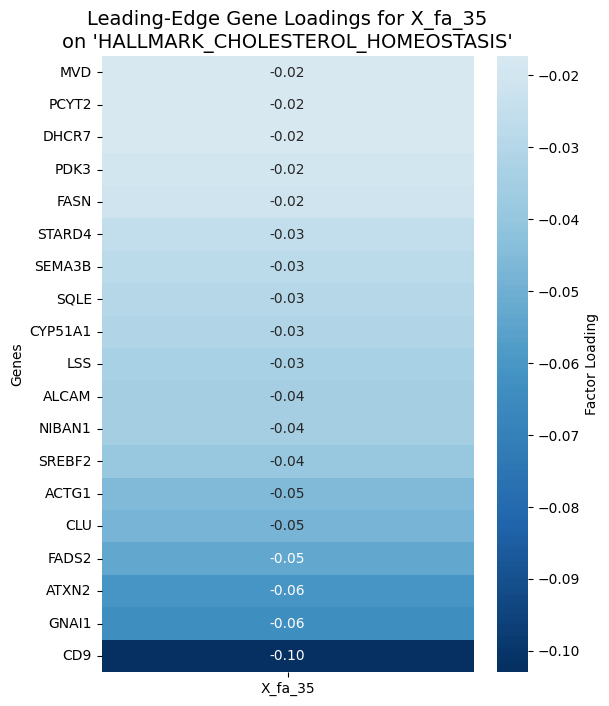

--- Top 5 Negative-Loading Genes ---
  - CD9: -0.1030
  - GNAI1: -0.0635
  - ATXN2: -0.0605
  - FADS2: -0.0537
  - CLU: -0.0478


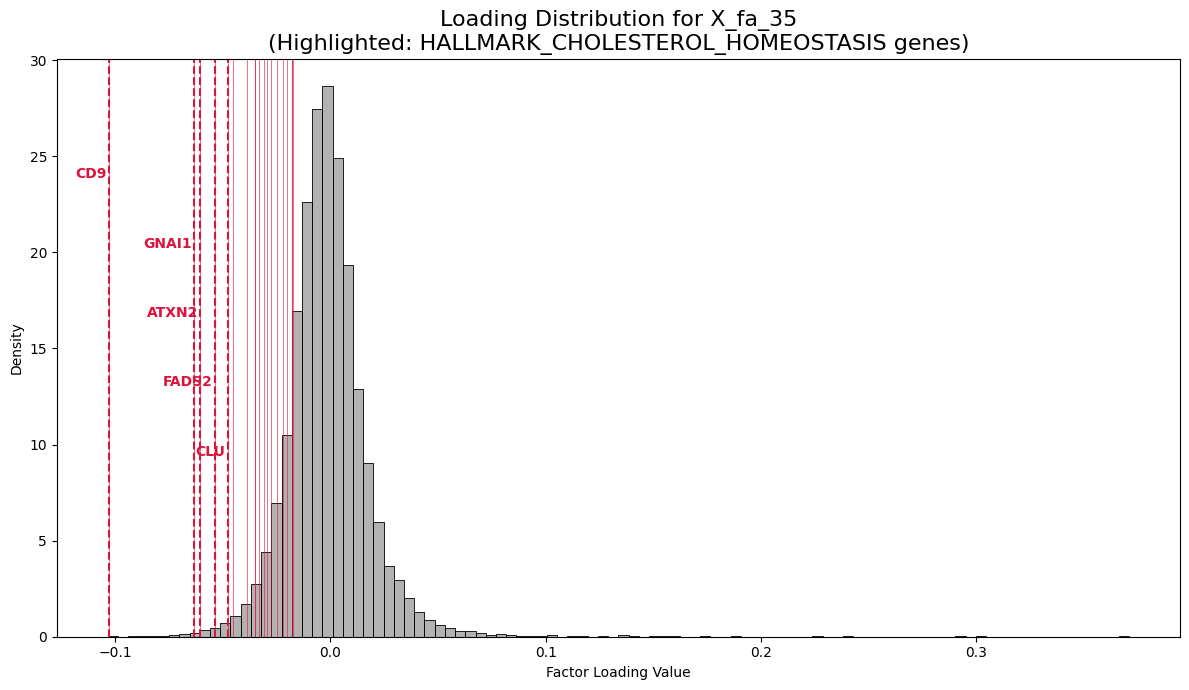


-- Pathway: HALLMARK_TGF_BETA_SIGNALING --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_TGF_BETA_SIGNALING' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 20 leading-edge genes for X_fa_35.
  -> Found 20 leading-edge genes.


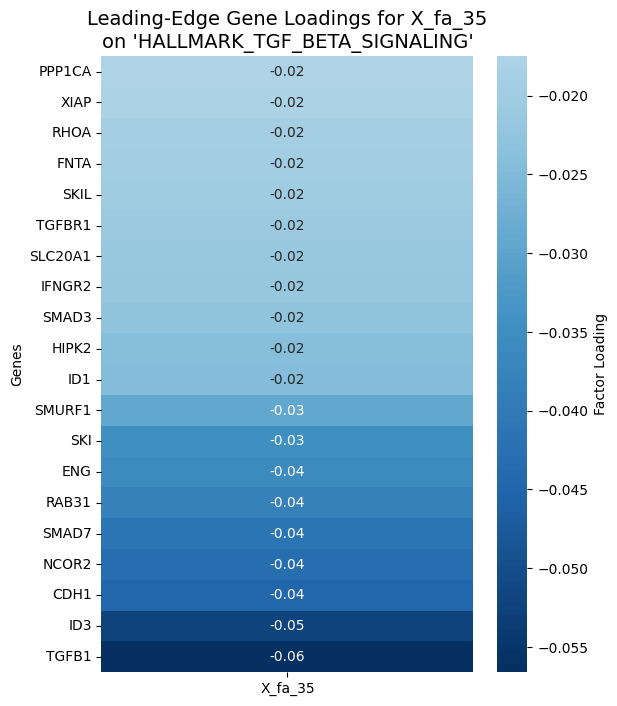

--- Top 5 Negative-Loading Genes ---
  - TGFB1: -0.0566
  - ID3: -0.0523
  - CDH1: -0.0449
  - NCOR2: -0.0430
  - SMAD7: -0.0414


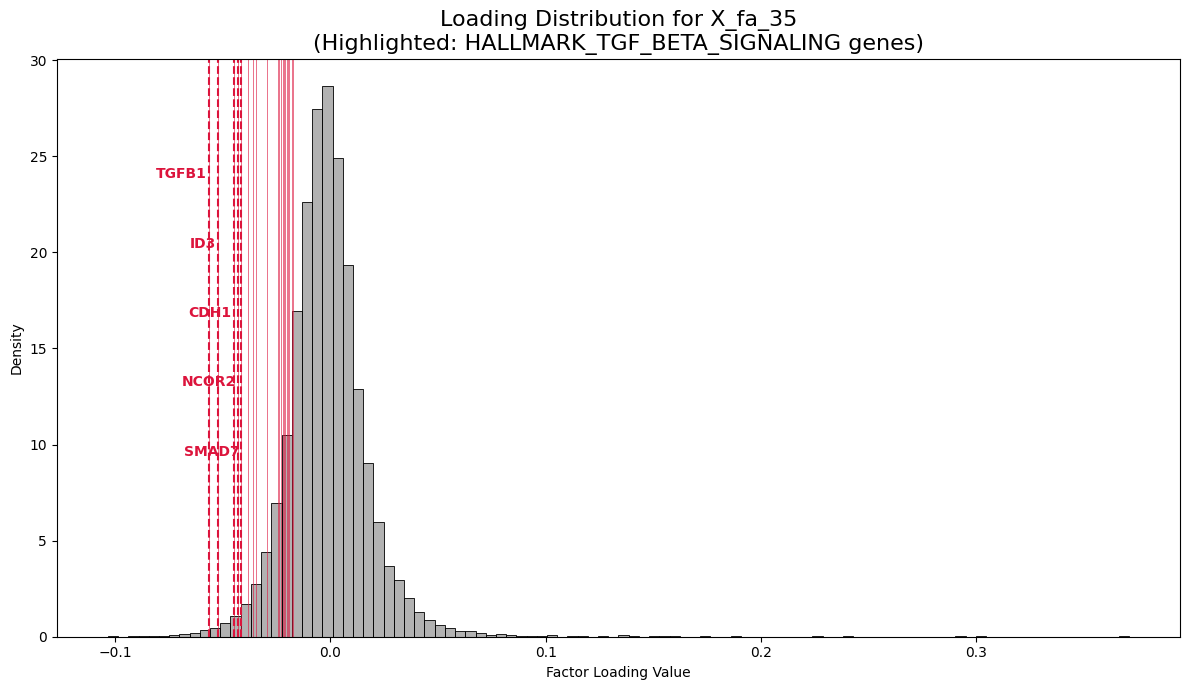


-- Pathway: HALLMARK_WNT_BETA_CATENIN_SIGNALING --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_WNT_BETA_CATENIN_SIGNALING' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 7 leading-edge genes for X_fa_35.
  -> Found 7 leading-edge genes.


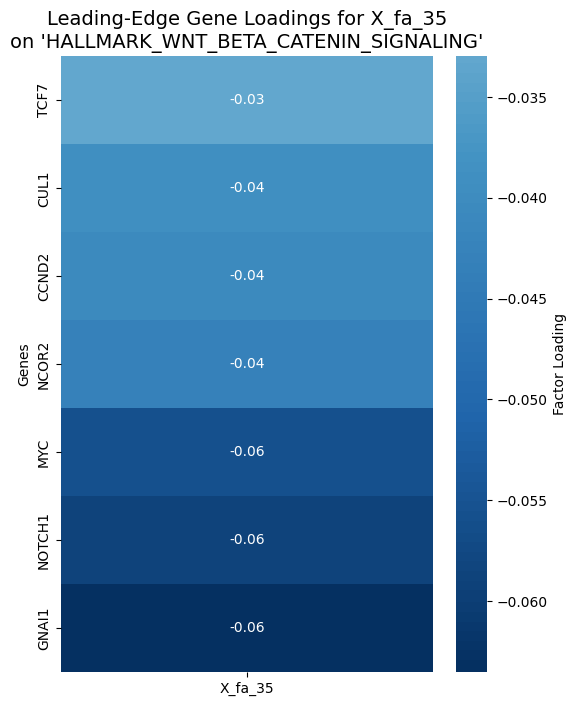

--- Top 5 Negative-Loading Genes ---
  - GNAI1: -0.0635
  - NOTCH1: -0.0589
  - MYC: -0.0556
  - NCOR2: -0.0430
  - CCND2: -0.0407


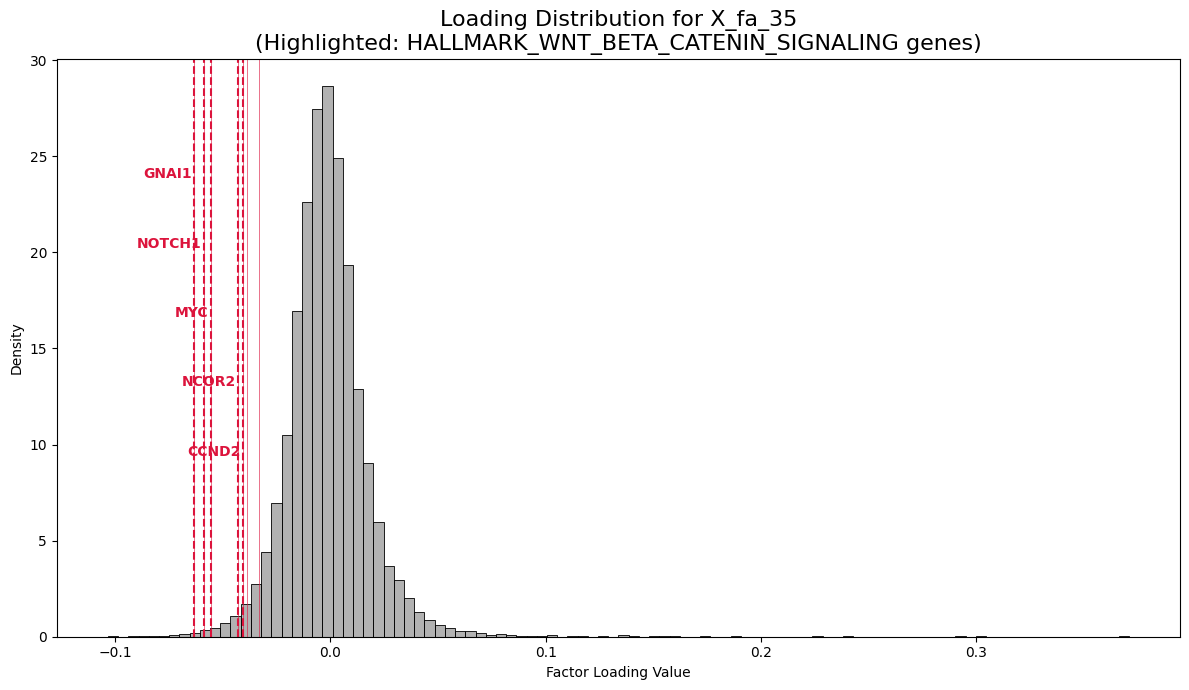


--- Analyzing Factor: X_fa_36 ---

--- Plotting activity for X_fa_36 in patients: P02, P09, P13 ---


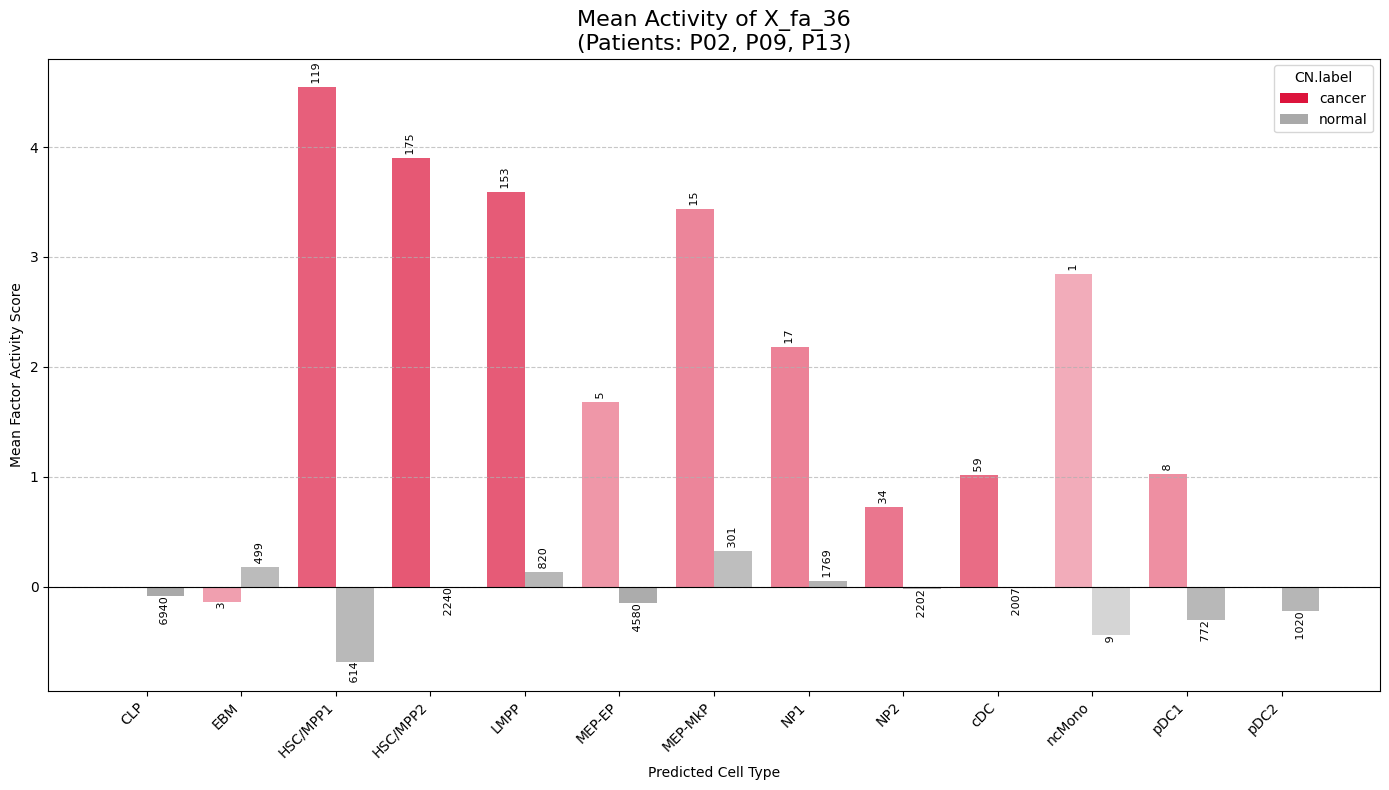


--- Running gene-level analysis for X_fa_36 ---

-- Pathway: HALLMARK_INTERFERON_ALPHA_RESPONSE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_INTERFERON_ALPHA_RESPONSE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 51 leading-edge genes for X_fa_36.
  -> Found 51 leading-edge genes.


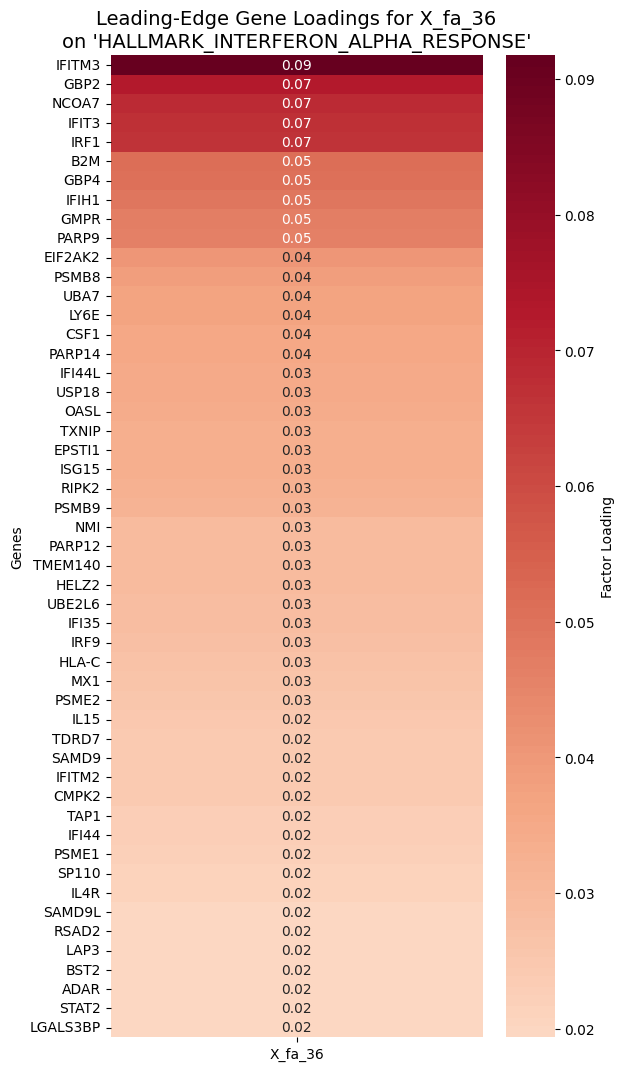

--- Top 5 Positive-Loading Genes ---
  - IRF1: 0.0663
  - IFIT3: 0.0667
  - NCOA7: 0.0683
  - GBP2: 0.0725
  - IFITM3: 0.0917


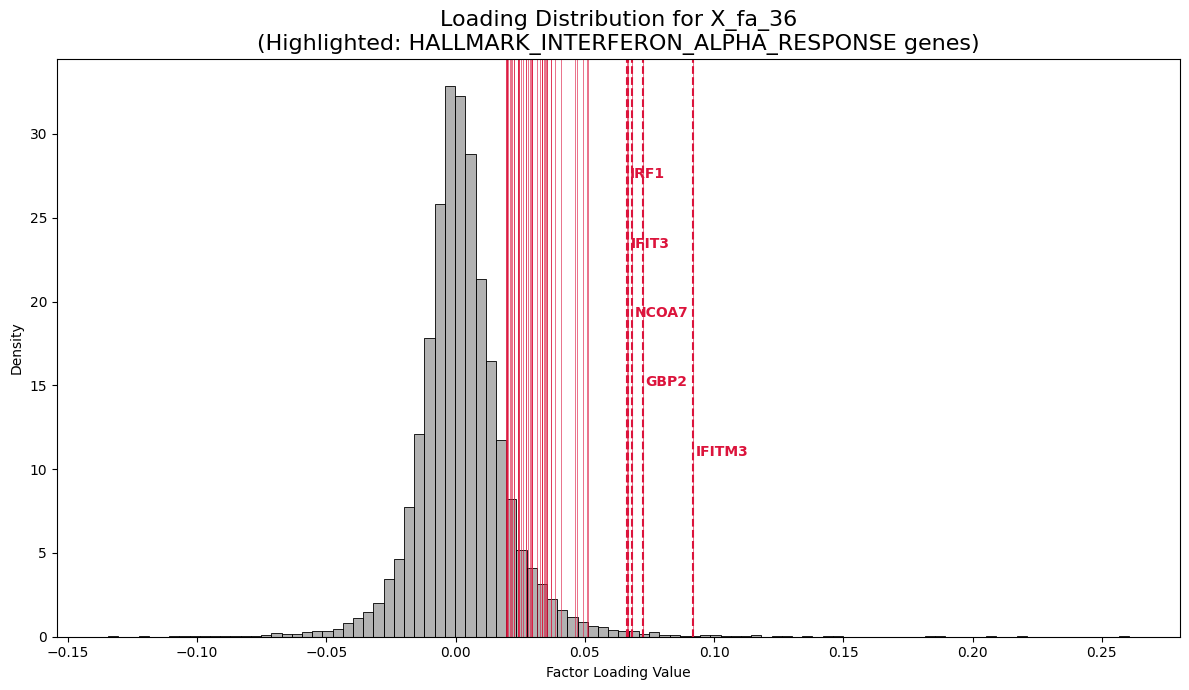


-- Pathway: HALLMARK_INTERFERON_GAMMA_RESPONSE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_INTERFERON_GAMMA_RESPONSE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 85 leading-edge genes for X_fa_36.
  -> Found 85 leading-edge genes.


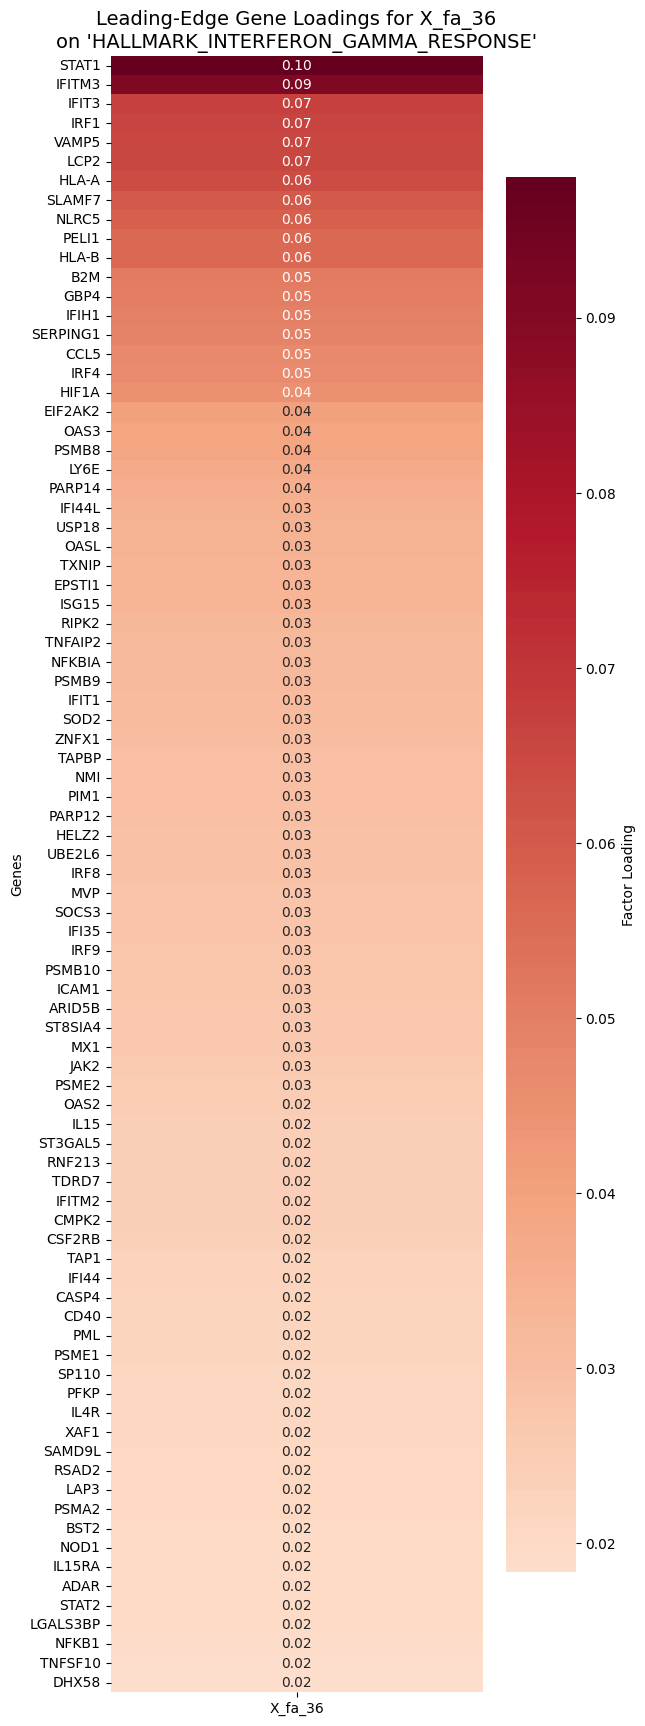

--- Top 5 Positive-Loading Genes ---
  - VAMP5: 0.0658
  - IRF1: 0.0663
  - IFIT3: 0.0667
  - IFITM3: 0.0917
  - STAT1: 0.0981


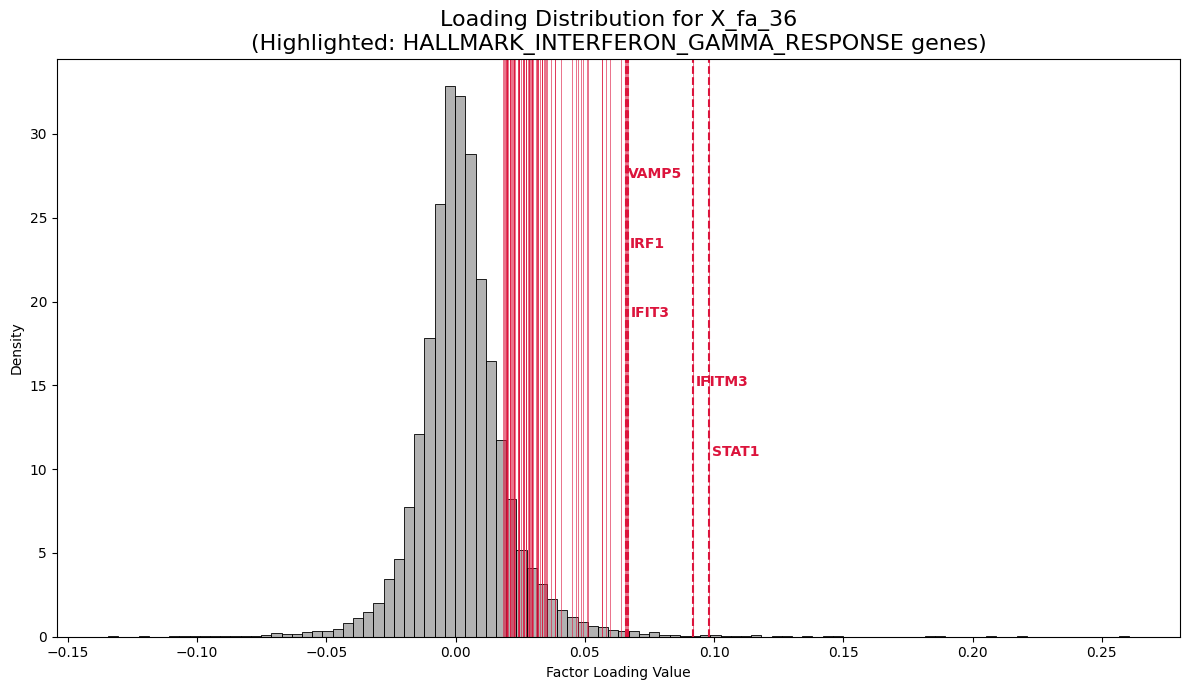


-- Pathway: HALLMARK_COAGULATION --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_COAGULATION' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 22 leading-edge genes for X_fa_36.
  -> Found 22 leading-edge genes.


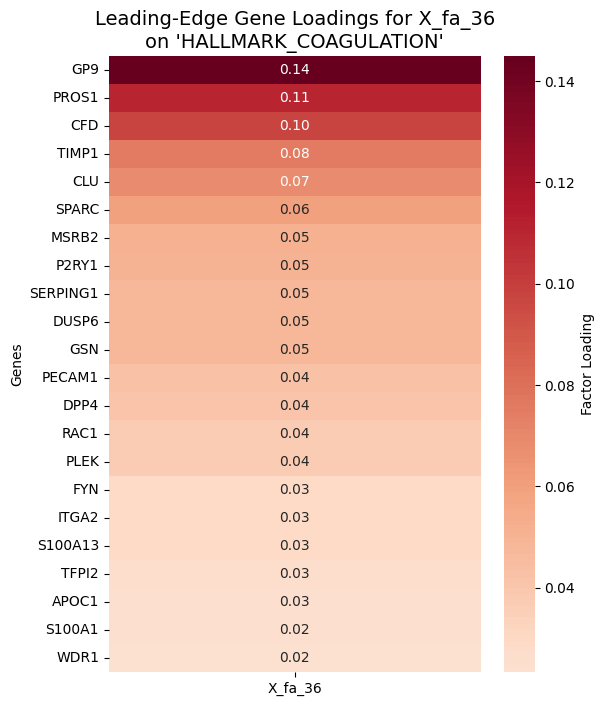

--- Top 5 Positive-Loading Genes ---
  - CLU: 0.0689
  - TIMP1: 0.0760
  - CFD: 0.0980
  - PROS1: 0.1100
  - GP9: 0.1449


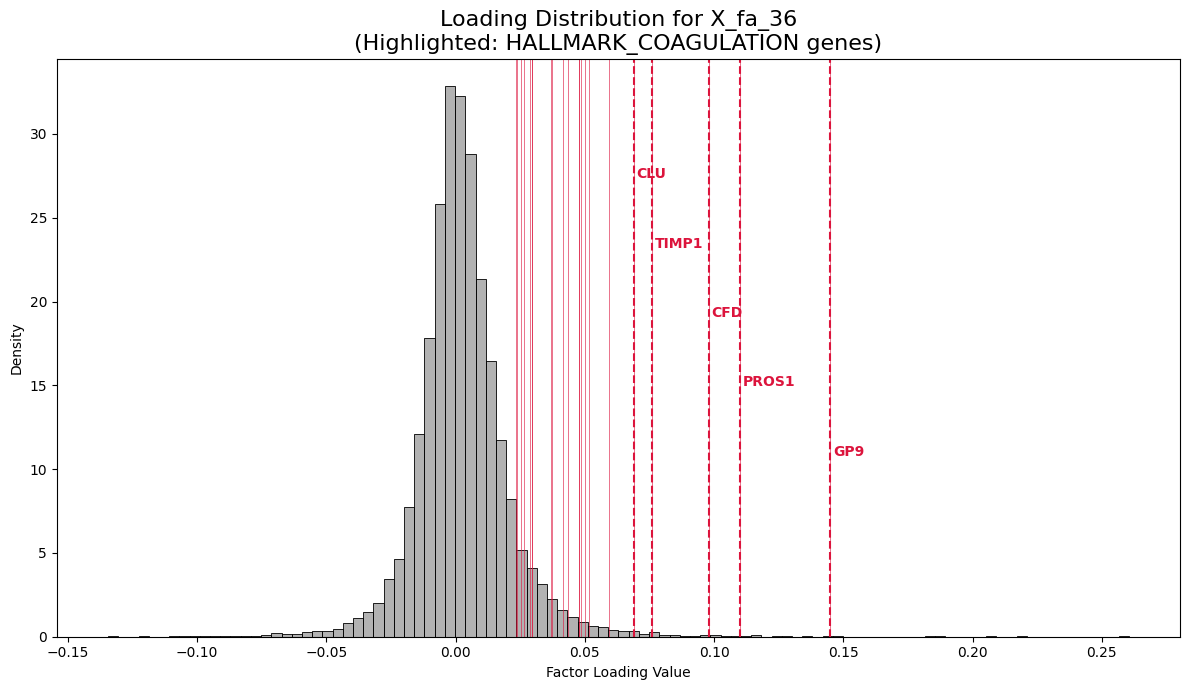


-- Pathway: HALLMARK_MYOGENESIS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_MYOGENESIS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 41 leading-edge genes for X_fa_36.
  -> Found 41 leading-edge genes.


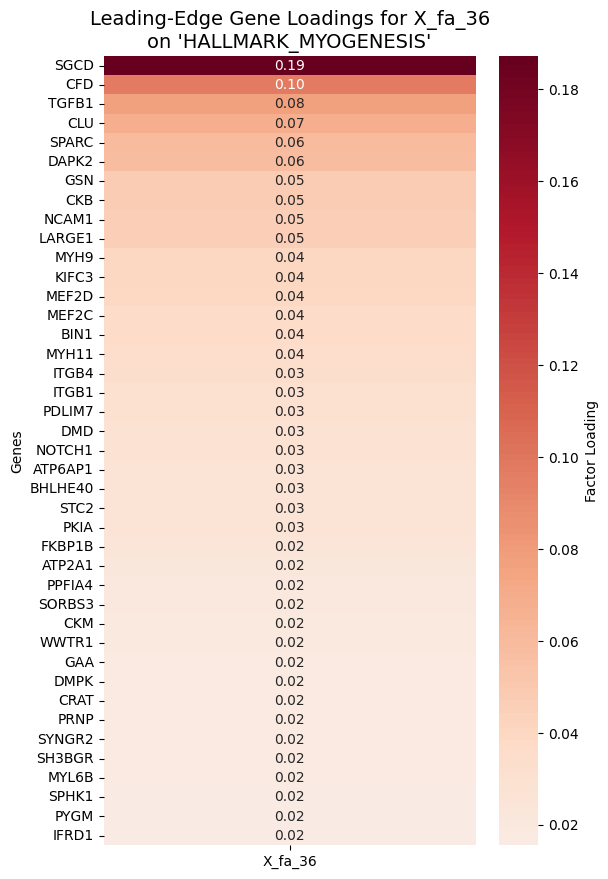

--- Top 5 Positive-Loading Genes ---
  - SPARC: 0.0593
  - CLU: 0.0689
  - TGFB1: 0.0766
  - CFD: 0.0980
  - SGCD: 0.1873


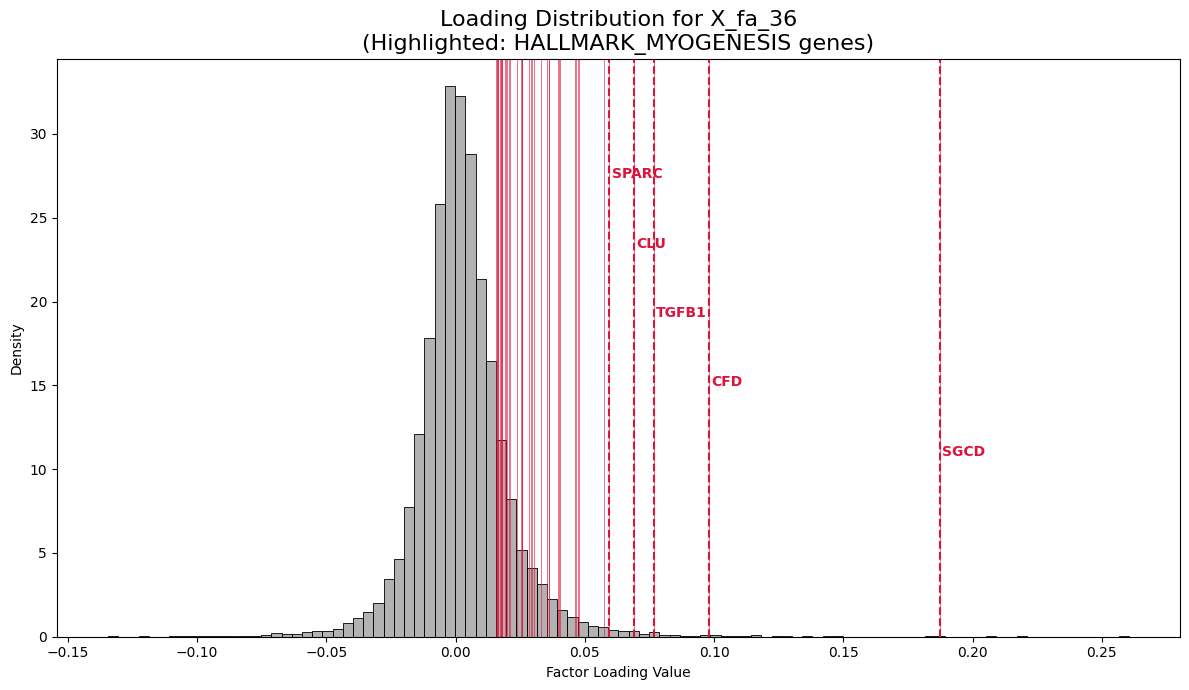


-- Pathway: HALLMARK_TNFA_SIGNALING_VIA_NFKB --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_TNFA_SIGNALING_VIA_NFKB' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 65 leading-edge genes for X_fa_36.
  -> Found 65 leading-edge genes.


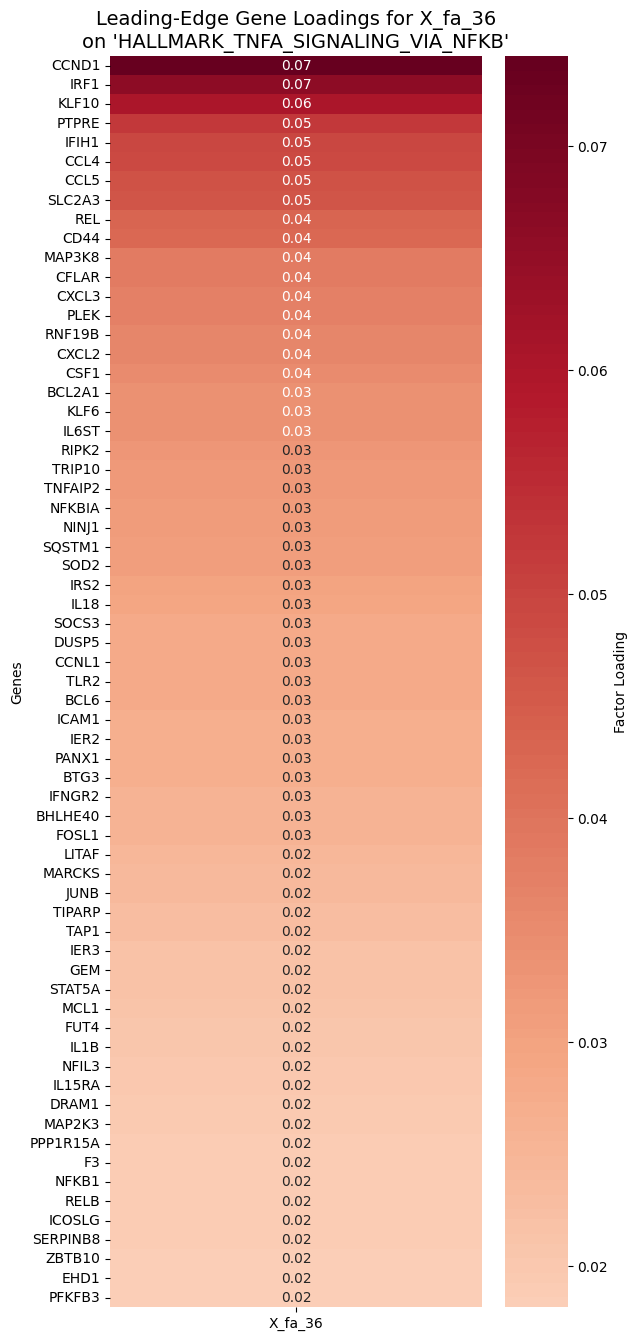

--- Top 5 Positive-Loading Genes ---
  - IFIH1: 0.0493
  - PTPRE: 0.0521
  - KLF10: 0.0602
  - IRF1: 0.0663
  - CCND1: 0.0740


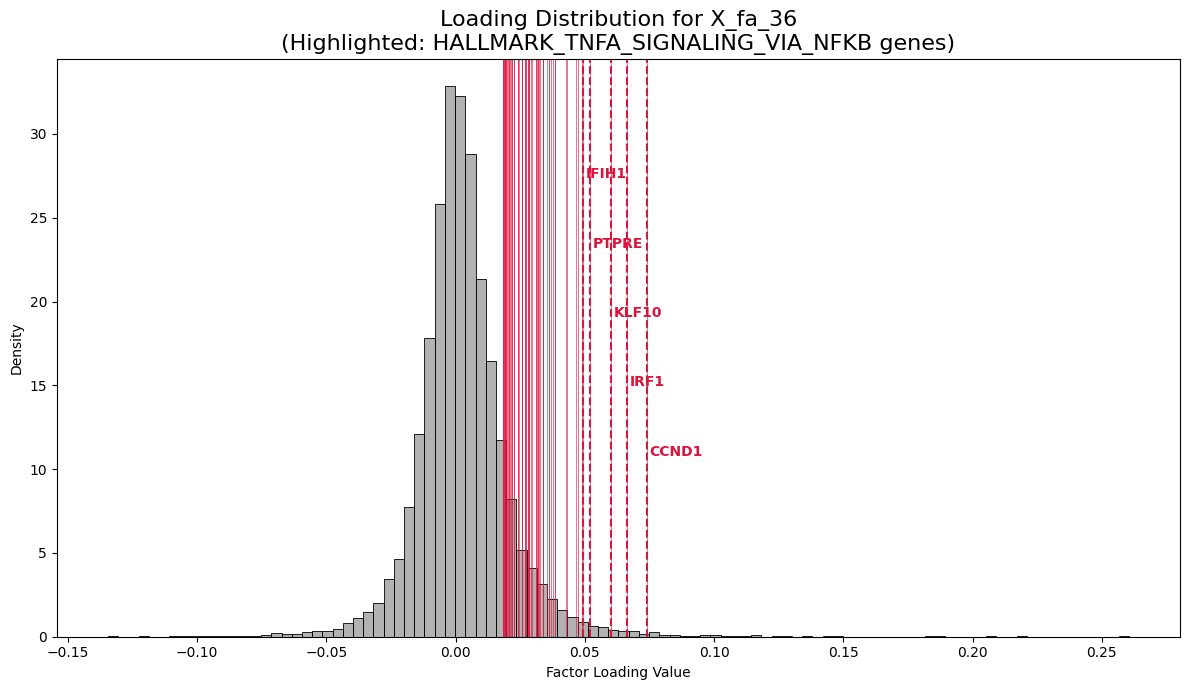


-- Pathway: HALLMARK_APOPTOSIS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_APOPTOSIS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 41 leading-edge genes for X_fa_36.
  -> Found 41 leading-edge genes.


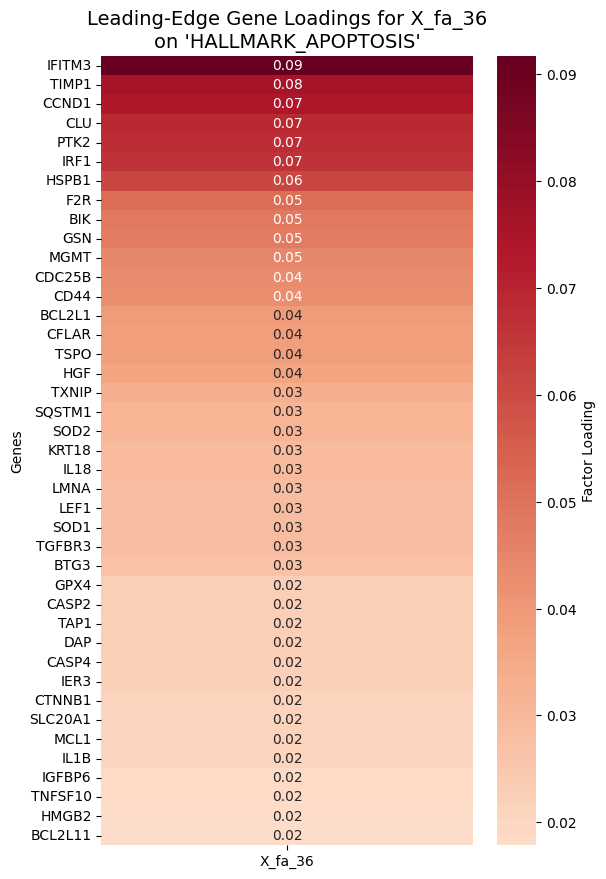

--- Top 5 Positive-Loading Genes ---
  - PTK2: 0.0679
  - CLU: 0.0689
  - CCND1: 0.0740
  - TIMP1: 0.0760
  - IFITM3: 0.0917


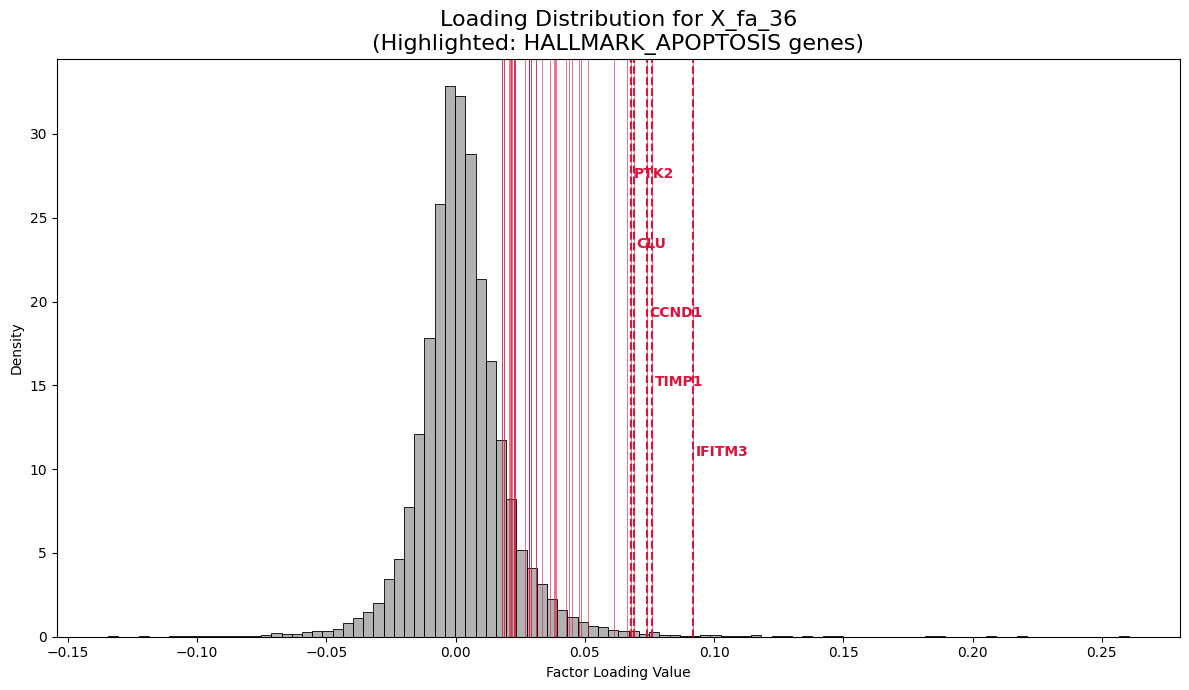


-- Pathway: HALLMARK_COMPLEMENT --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_COMPLEMENT' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 68 leading-edge genes for X_fa_36.
  -> Found 68 leading-edge genes.


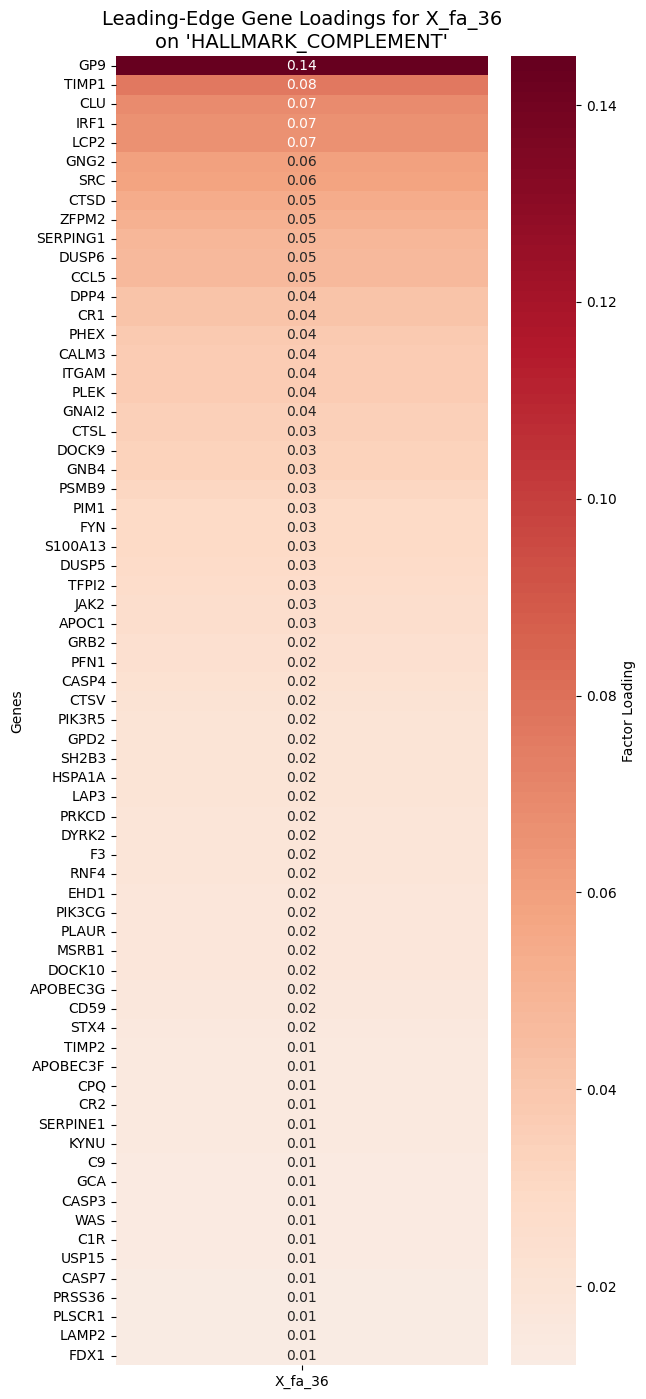

--- Top 5 Positive-Loading Genes ---
  - LCP2: 0.0657
  - IRF1: 0.0663
  - CLU: 0.0689
  - TIMP1: 0.0760
  - GP9: 0.1449


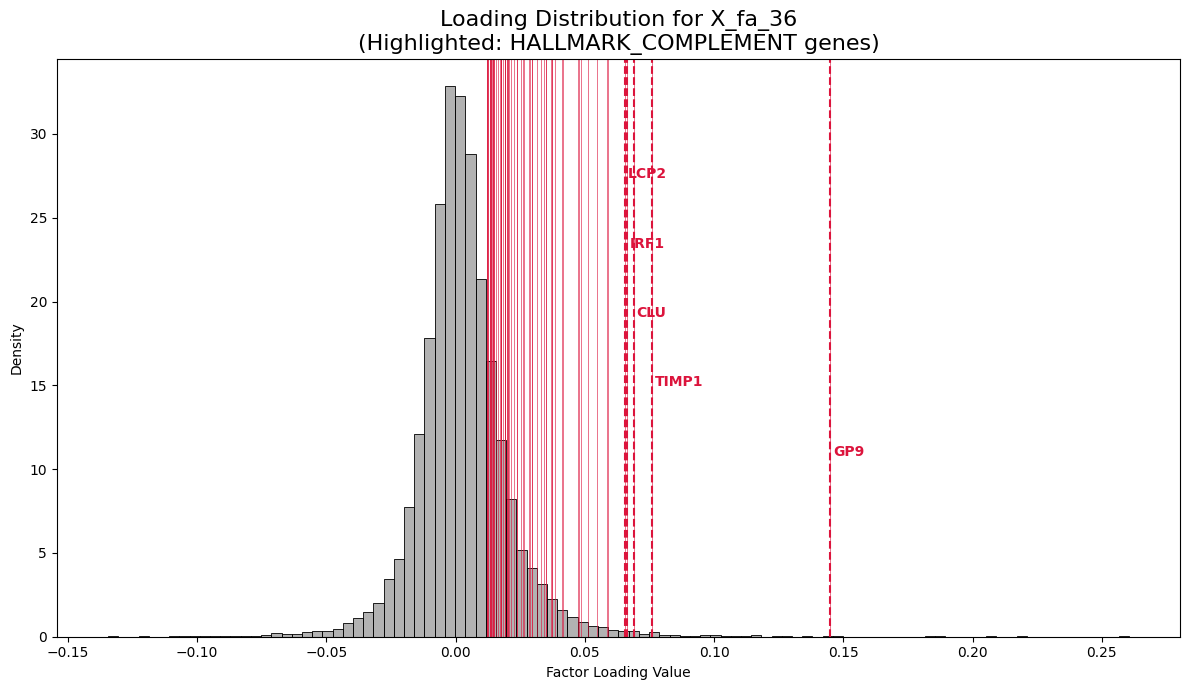


-- Pathway: HALLMARK_INFLAMMATORY_RESPONSE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_INFLAMMATORY_RESPONSE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 56 leading-edge genes for X_fa_36.
  -> Found 56 leading-edge genes.


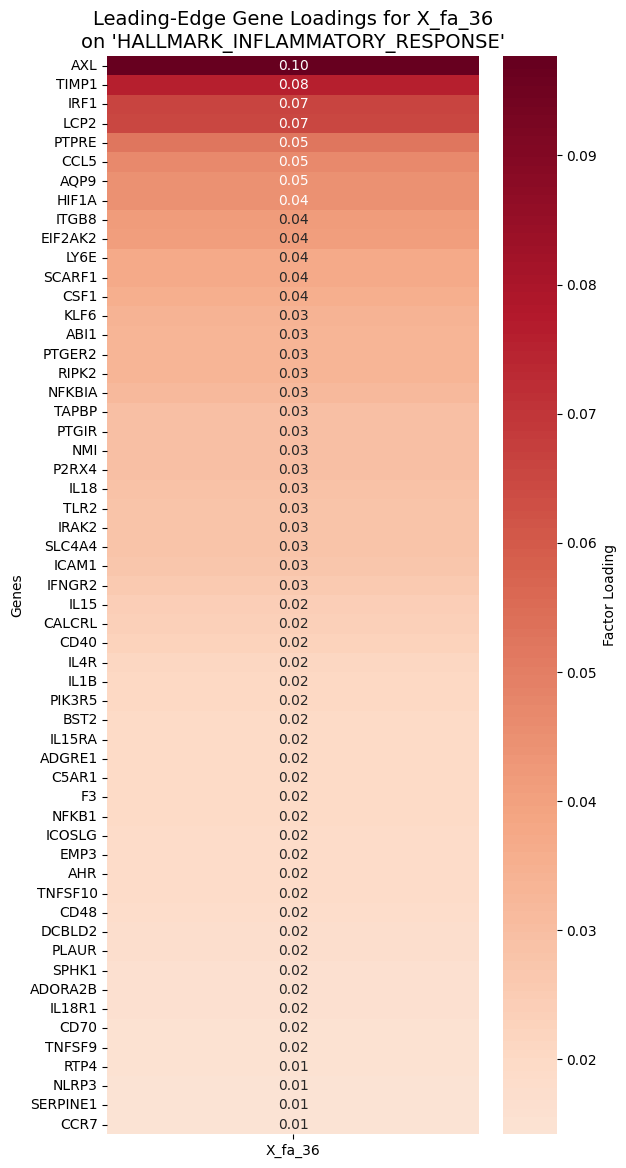

--- Top 5 Positive-Loading Genes ---
  - PTPRE: 0.0521
  - LCP2: 0.0657
  - IRF1: 0.0663
  - TIMP1: 0.0760
  - AXL: 0.0977


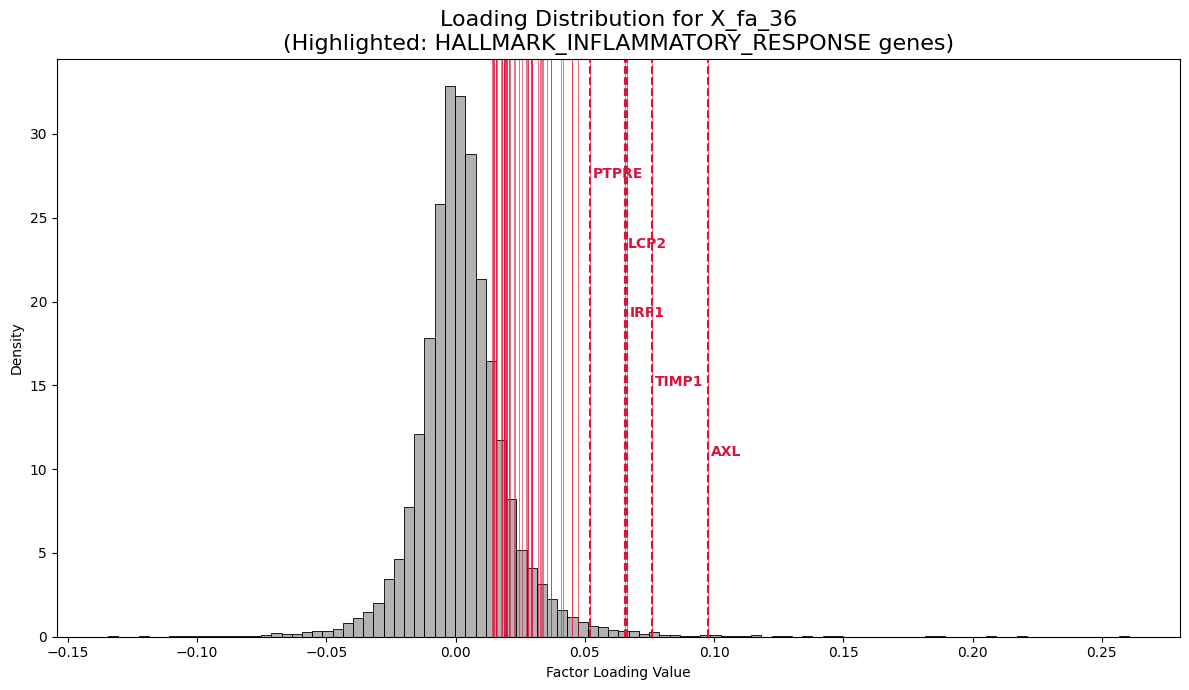


-- Pathway: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 31 leading-edge genes for X_fa_36.
  -> Found 31 leading-edge genes.


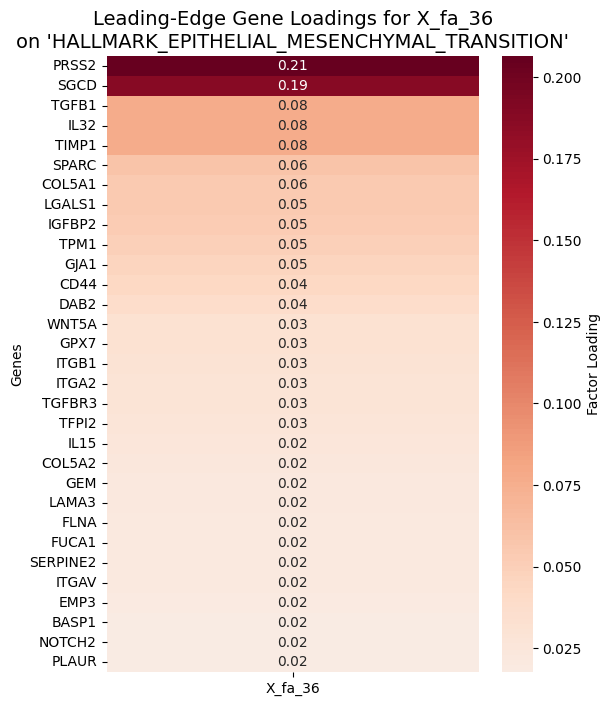

--- Top 5 Positive-Loading Genes ---
  - TIMP1: 0.0760
  - IL32: 0.0760
  - TGFB1: 0.0766
  - SGCD: 0.1873
  - PRSS2: 0.2064


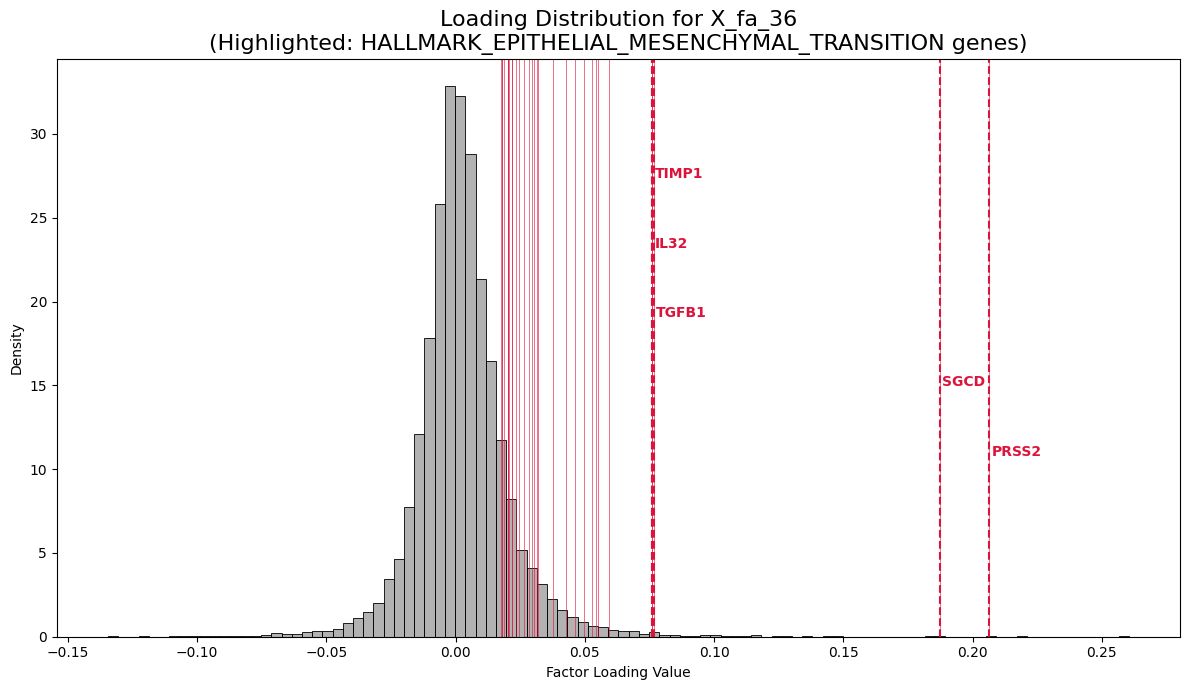


-- Pathway: HALLMARK_MYC_TARGETS_V2 --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_MYC_TARGETS_V2' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 29 leading-edge genes for X_fa_36.
  -> Found 29 leading-edge genes.


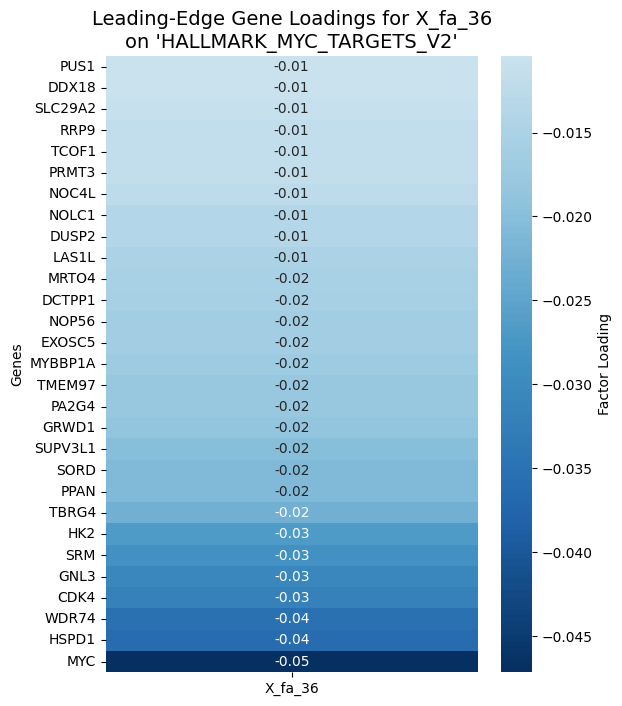

--- Top 5 Negative-Loading Genes ---
  - MYC: -0.0471
  - HSPD1: -0.0362
  - WDR74: -0.0353
  - CDK4: -0.0320
  - GNL3: -0.0309


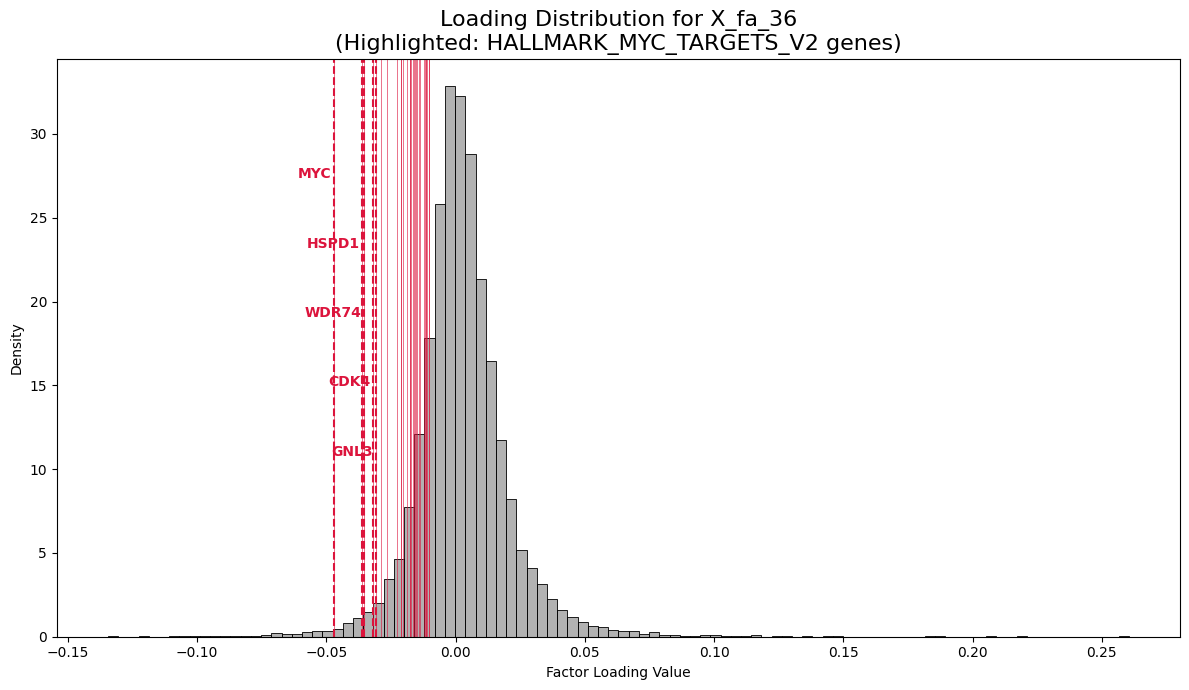


--- Analyzing Factor: X_fa_46 ---

--- Plotting activity for X_fa_46 in patients: P02, P13 ---


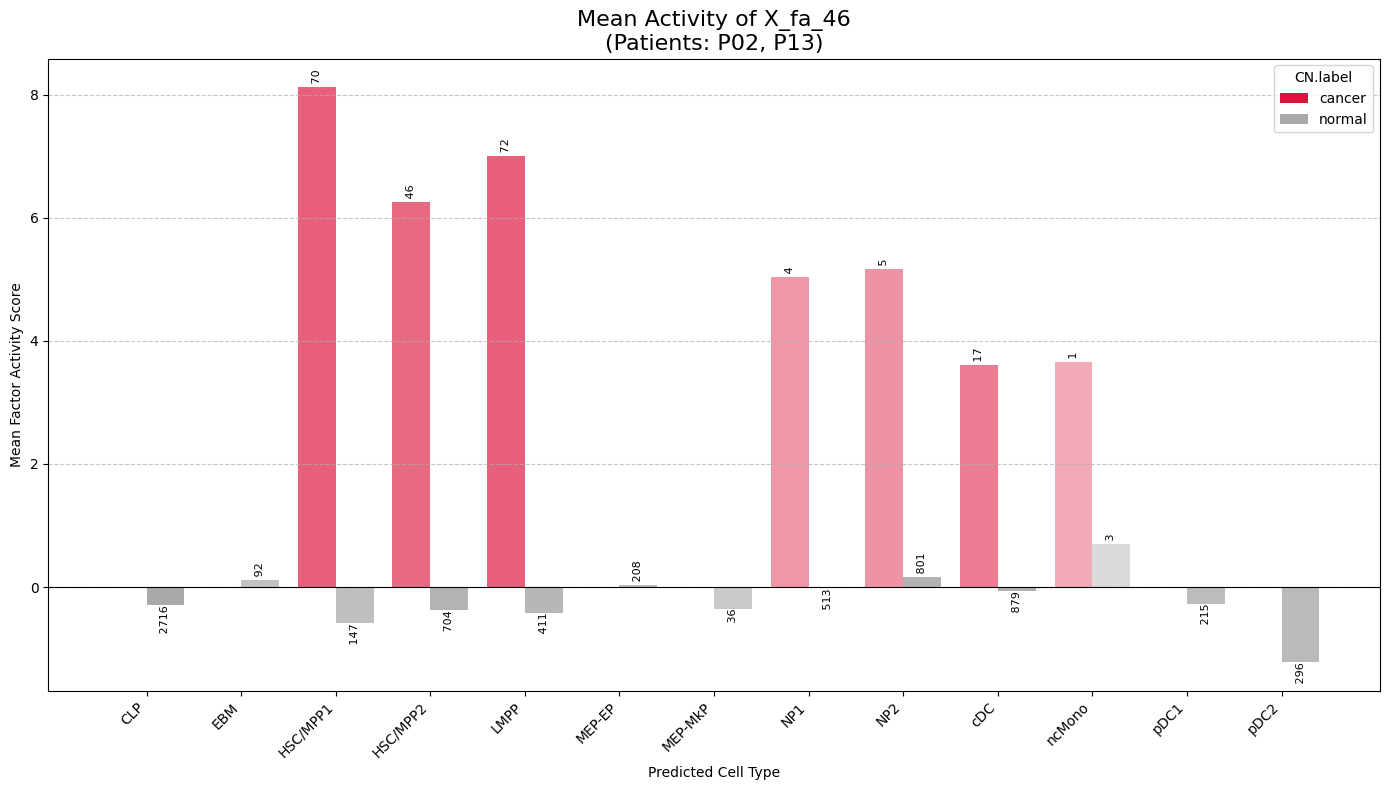


--- Running gene-level analysis for X_fa_46 ---

-- Pathway: HALLMARK_INTERFERON_ALPHA_RESPONSE --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_INTERFERON_ALPHA_RESPONSE' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 34 leading-edge genes for X_fa_46.
  -> Found 34 leading-edge genes.


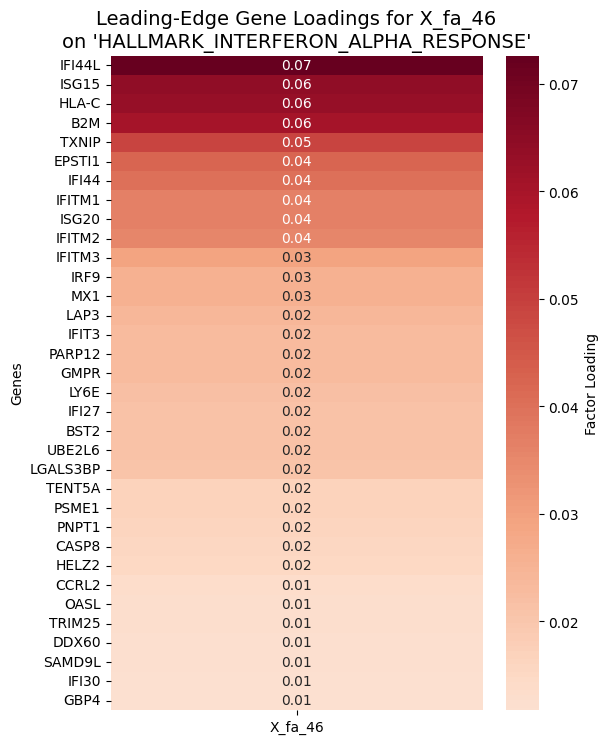

--- Top 5 Positive-Loading Genes ---
  - TXNIP: 0.0490
  - B2M: 0.0607
  - HLA-C: 0.0632
  - ISG15: 0.0643
  - IFI44L: 0.0726


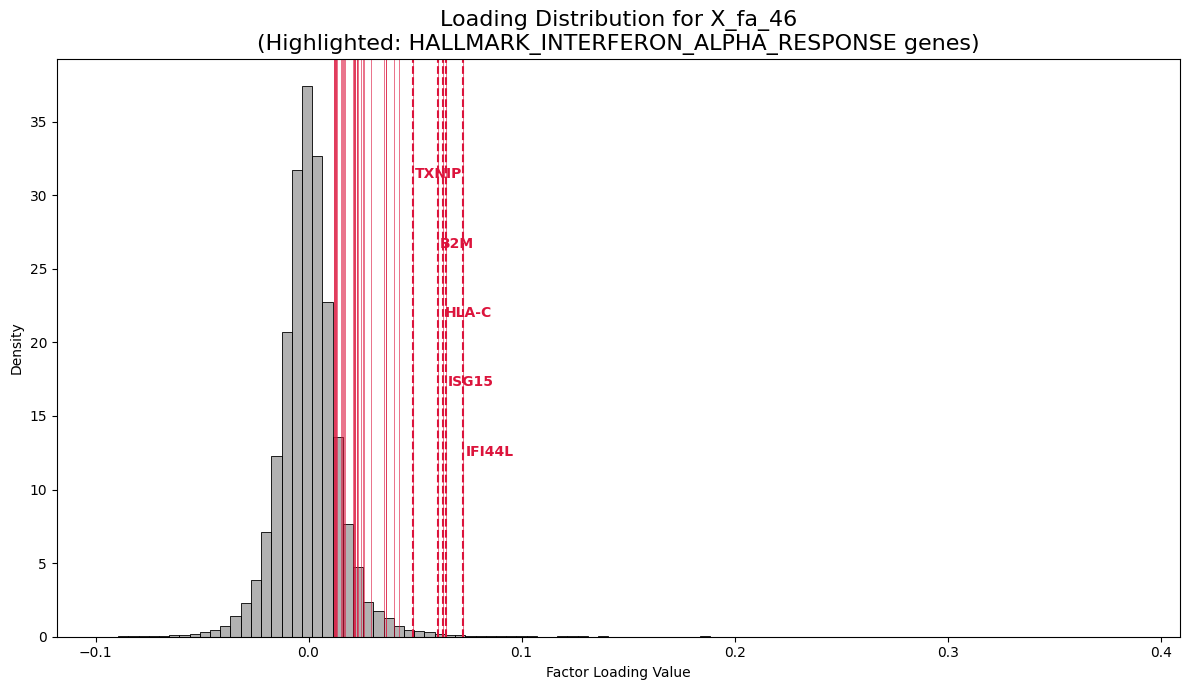


-- Pathway: HALLMARK_E2F_TARGETS --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_E2F_TARGETS' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 69 leading-edge genes for X_fa_46.
  -> Found 69 leading-edge genes.


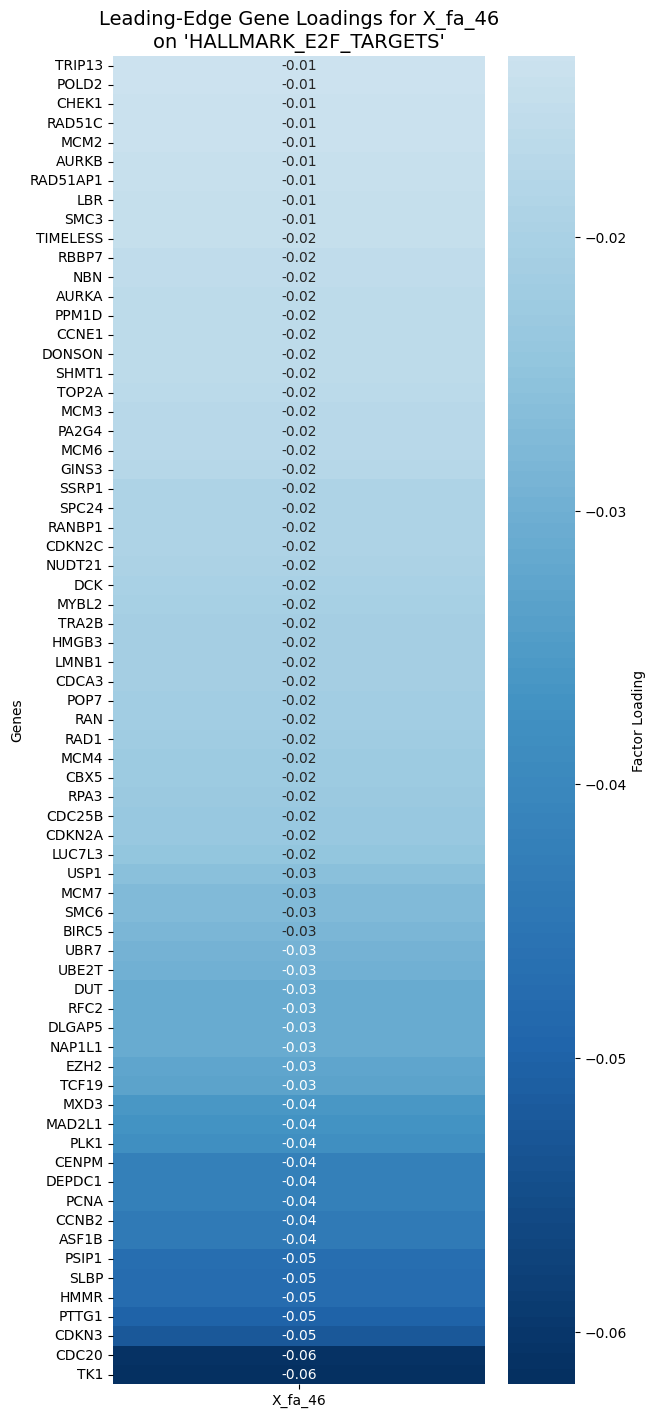

--- Top 5 Negative-Loading Genes ---
  - TK1: -0.0619
  - CDC20: -0.0612
  - CDKN3: -0.0524
  - PTTG1: -0.0498
  - HMMR: -0.0477


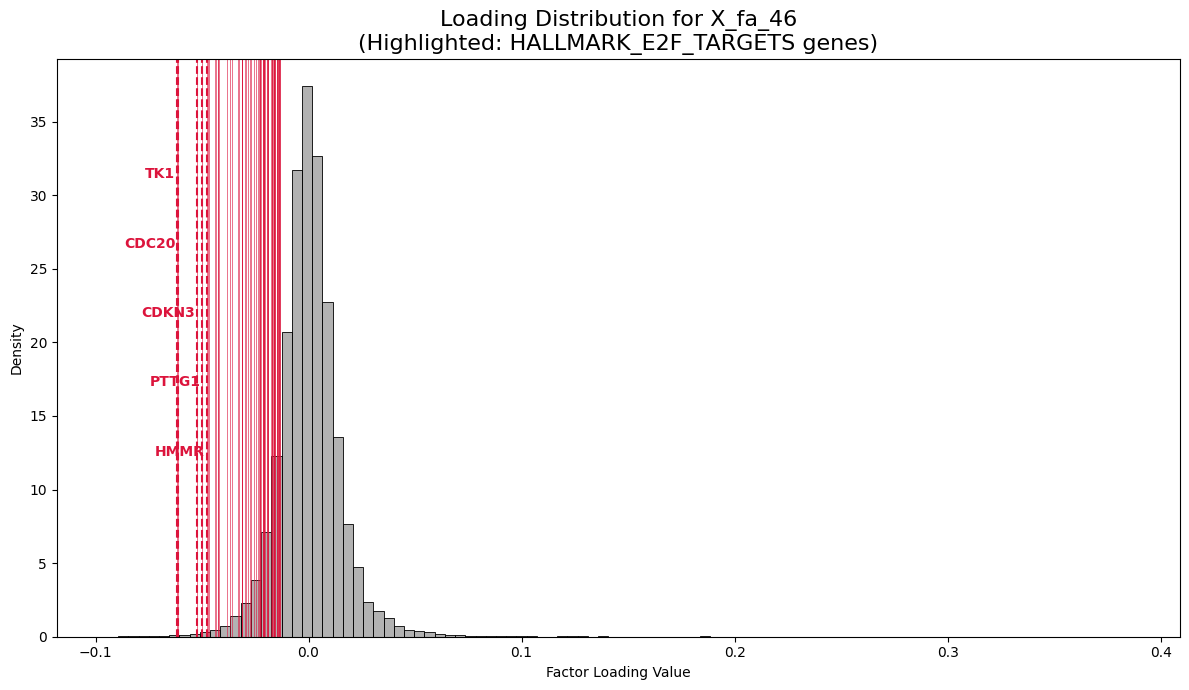


-- Pathway: HALLMARK_G2M_CHECKPOINT --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_G2M_CHECKPOINT' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 53 leading-edge genes for X_fa_46.
  -> Found 53 leading-edge genes.


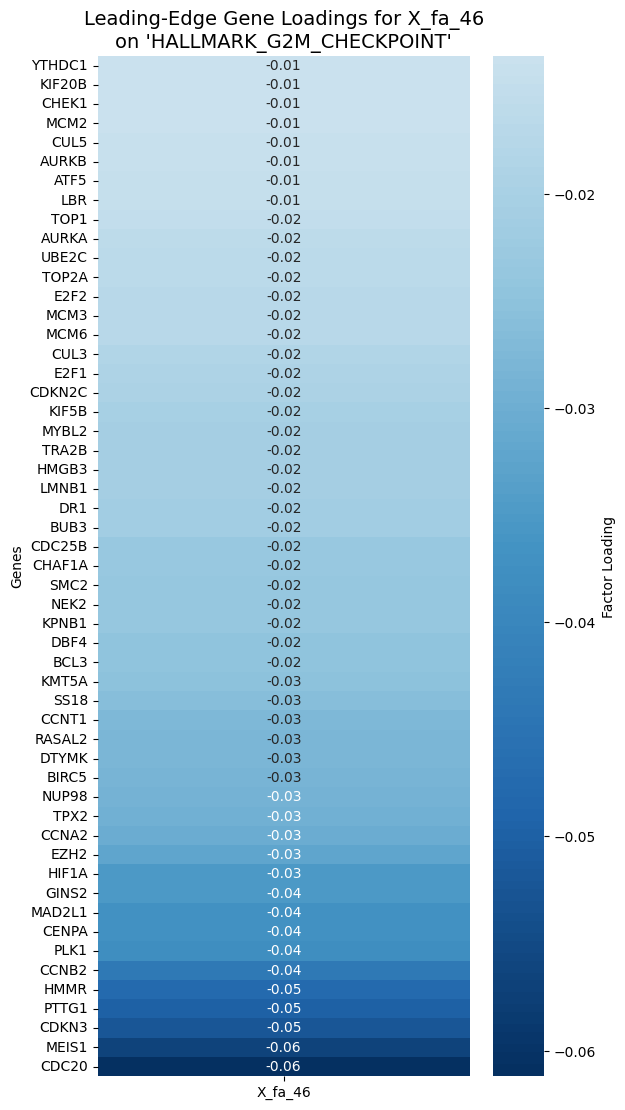

--- Top 5 Negative-Loading Genes ---
  - CDC20: -0.0612
  - MEIS1: -0.0564
  - CDKN3: -0.0524
  - PTTG1: -0.0498
  - HMMR: -0.0477


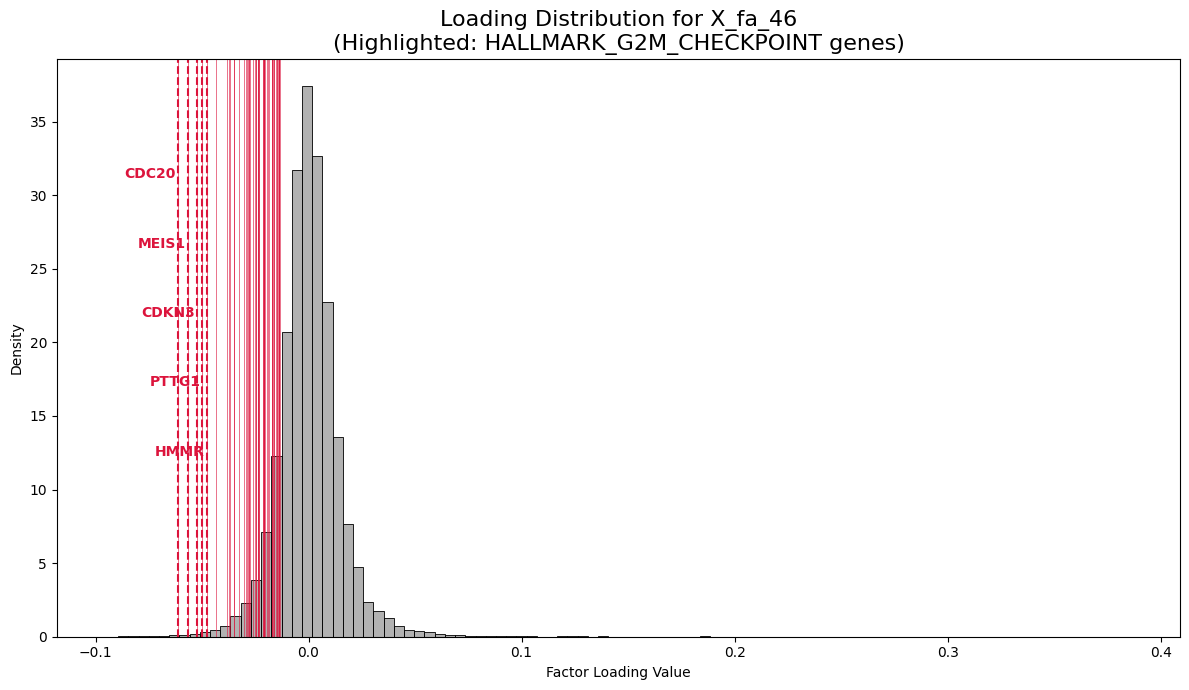


-- Pathway: HALLMARK_IL6_JAK_STAT3_SIGNALING --
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07
--- Analyzing GSEA results for pathway: 'HALLMARK_IL6_JAK_STAT3_SIGNALING' ---
Source directory: /home/minhang/mds_project/sc_classification/experiments/20250819_232404_fa_100_random_all_filtered_f85f0e07/analysis/factor_interpretation/gsea_on_factors_original
  - Found 19 leading-edge genes for X_fa_46.
  -> Found 19 leading-edge genes.


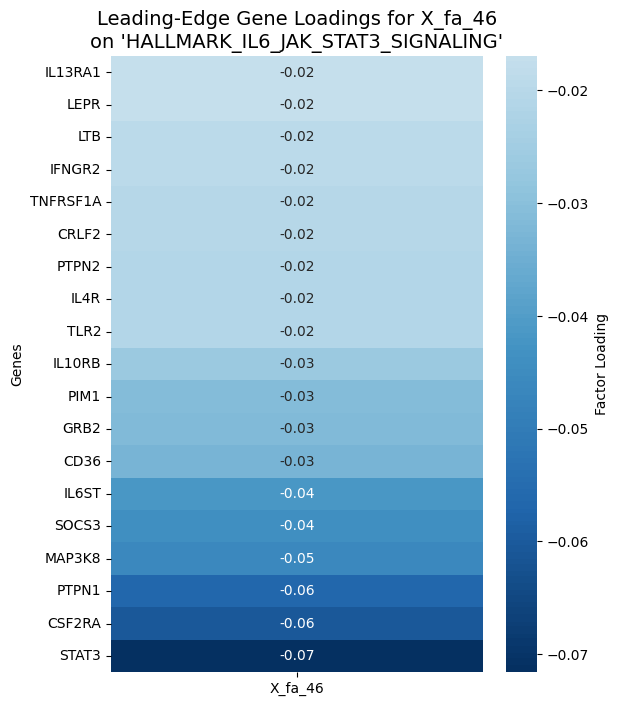

--- Top 5 Negative-Loading Genes ---
  - STAT3: -0.0716
  - CSF2RA: -0.0609
  - PTPN1: -0.0571
  - MAP3K8: -0.0459
  - SOCS3: -0.0442


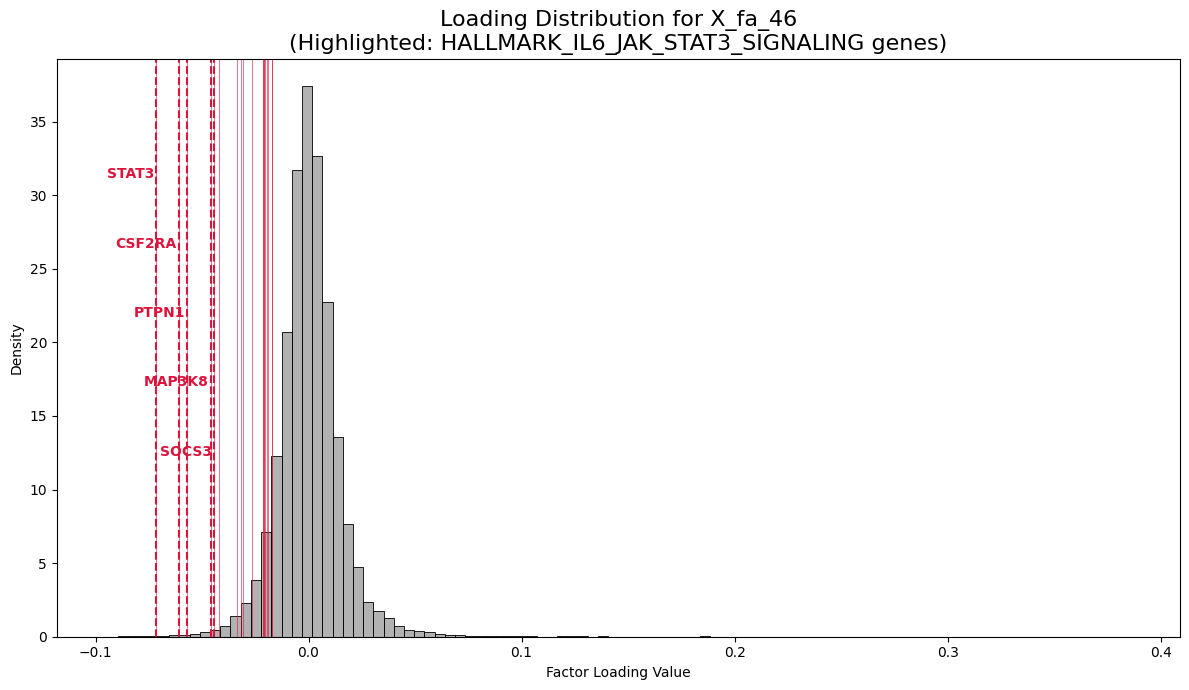

In [16]:
import warnings

print(f"\n{'='*80}")
print("--- Running Integrated Analysis for Key Factors and Pathways ---")
print(f"{'='*80}")

# --- 1. Consolidated Gene-Level Analysis Cases ---
# This dictionary maps a factor to the pathways it's associated with.
# !!! IMPORTANT !!!: Please verify the 'nes_direction' for each pathway based on your GSEA results.
# I have made educated guesses, but they must be confirmed for the plots to be correct.
cases_to_analyze = {
    18: [
        {'pathway': 'HALLMARK_P53_PATHWAY', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_UV_RESPONSE_UP', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_MYC_TARGETS_V2', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_G2M_CHECKPOINT', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_UV_RESPONSE_DN', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_MITOTIC_SPINDLE', 'nes_direction': 'neg'}
    ],
    33: [
        {'pathway': 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_G2M_CHECKPOINT', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_E2F_TARGETS', 'nes_direction': 'neg'}, 
        {'pathway': 'HALLMARK_SPERMATOGENESIS', 'nes_direction': 'neg'}, 
        {'pathway': 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'nes_direction': 'neg'}
    ],
    35: [
        {'pathway': 'HALLMARK_OXIDATIVE_PHOSPHORYLATION', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_MYC_TARGETS_V1', 'nes_direction': 'pos'}, 
        {'pathway': 'HALLMARK_E2F_TARGETS', 'nes_direction': 'pos'}, 
        {'pathway': 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_APICAL_JUNCTION', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_TGF_BETA_SIGNALING', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'nes_direction': 'neg'}
    ],
    36: [
        {'pathway': 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_COAGULATION', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_MYOGENESIS', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_APOPTOSIS', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_COMPLEMENT', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_INFLAMMATORY_RESPONSE', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_MYC_TARGETS_V2', 'nes_direction': 'neg'}
    ],
    46: [
        {'pathway': 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'nes_direction': 'pos'},
        {'pathway': 'HALLMARK_E2F_TARGETS', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_G2M_CHECKPOINT', 'nes_direction': 'neg'},
        {'pathway': 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'nes_direction': 'neg'}
    ]
}

# --- 2. Factor-to-Patient Mapping for Cell-Level Analysis ---
# Maps a factor to the specific patient subset where its activity is most relevant.
factor_patient_map = {
    18: ['P03'],
    33: ['P09', 'P13'], # Example: patients with high activity for this factor
    35: ['P09'],
    36: ['P02', 'P09', 'P13'],
    46: ['P02', 'P13']
}

# Ensure required variables are loaded from previous cells
try:
    exp_key = "per_patient_all_filtered"
    exp_id = experiments[exp_key]['id']
    adata_path = experiments[exp_key]['path'] / "models" / "fa_100" / "transformed_data.h5ad"
    adata_transformed = sc.read_h5ad(adata_path)
    
    factor_cols = [f'X_fa_{i+1}' for i in range(adata_transformed.varm['FA_loadings'].shape[1])]
    loadings_df = pd.DataFrame(adata_transformed.varm['FA_loadings'], index=adata_transformed.var_names, columns=factor_cols)
    print("Successfully loaded data and factor loadings.")

except NameError as e:
    print(f"\n[ERROR] Could not run analysis: A required variable is not defined.")
    print(f"Please ensure 'analyzer', 'experiments' are loaded in your notebook.")
    raise e

# --- 3. Run Analysis ---
# The outer loop iterates through the factors we want to analyze at the cell level.
for factor_num, patients in factor_patient_map.items():
    factor_id = f'X_fa_{factor_num}'
    print(f"\n{'='*40}\n--- Analyzing Factor: {factor_id} ---\n{'='*40}")

    # --- a. Plot Cell-Level Factor Activity ---
    print(f"\n--- Plotting activity for {factor_id} in patients: {', '.join(patients)} ---")
    plot_factor_activity(
        adata=adata_transformed,
        factor_id=factor_id,
        patients_of_interest=patients,
        cell_type_col='predicted.annotation'
    )

    # --- b. Plot Gene-Level Details (if defined in cases_to_analyze) ---
    if factor_num in cases_to_analyze:
        print(f"\n--- Running gene-level analysis for {factor_id} ---")
        for case in cases_to_analyze[factor_num]:
            pathway_name = case['pathway']
            direction = case['nes_direction']
            
            print(f"\n-- Pathway: {pathway_name} --")
            
            with warnings.catch_warnings(): # Suppress GSEA analyzer's loading messages
                warnings.simplefilter("ignore")
                le_dict = analyzer.analyze_unsupervised_gsea_overlap(
                    experiment_id=exp_id, factors=[factor_id], pathway_name=pathway_name
                )
            
            leading_genes = sorted(list(le_dict.get(factor_id, set())))

            if not leading_genes:
                print(f"  -> No significant leading-edge genes found. Skipping plots.")
                continue
            
            print(f"  -> Found {len(leading_genes)} leading-edge genes.")
            
            # Plot Gene Loading Heatmap
            plot_gene_loading_heatmap(
                loadings_series=loadings_df.loc[leading_genes, factor_id],
                title=f"Leading-Edge Gene Loadings for {factor_id}\non '{pathway_name}'"
            )
            
            # Plot Gene Loading Distribution
            plot_gene_loading_distribution(
                all_loadings_series=loadings_df[factor_id],
                leading_edge_genes=leading_genes,
                enrichment_direction=direction,
                title=f"Loading Distribution for {factor_id}\n(Highlighted: {pathway_name} genes)"
            )